In [ ]:
# %%

import holidays
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

In [ ]:
# %%

# Load and display the data
solar_232215 = pd.read_csv('data/solar_232215.csv', delimiter=',', decimal='.')
solar_232215

,timestamp,raw,temperature,modified1,modified2,modified3
0,1612224000000,0.0,-3.9,0.0,0.0,0.0
1,1612227600000,0.0,-3.5,0.0,0.0,0.0
2,1612231200000,0.0,-3.0,0.0,0.0,0.0
3,1612234800000,0.0,-2.6,0.0,0.0,0.0
4,1612238400000,0.0,-2.4,0.0,0.0,0.0
...,...,...,...,...,...,...
17011,1675278000000,0.0,0.0,0.0,0.0,0.0
17012,1675281600000,0.0,0.1,0.0,0.0,0.0
17013,1675285200000,0.0,0.1,0.0,0.0,0.0
17014,1675288800000,0.0,0.2,0.0,0.0,0.0


# %% [markdown]

 The dataset consists of 17,016 entries with six columns:
 1. **timestamp**: Unix timestamp (in milliseconds).
 2. **raw**: Electricity production from the PV panel corresponding to each timestamp.
 3. **temperature**: Temperature readings corresponding to each timestamp.
 4. **modified1, modified2, modified3**: Modified versions of the raw production data. These columns have some missing values.

 Overall with the provided data it is possible to analyze the electricity production of the PV panel and its relationship with temperature.

 To analyze the PV panel's production effectively, the following potential external data sources might be useful:
 1. **Solar Irradiance Data**: Information on solar irradiance levels (sunlight intensity) would help assess the PV production in relation to the available sunlight.
 2. **Weather Conditions**: Data on cloud cover, humidity, or precipitation could help explain variations in electricity production that temperature alone might not cover.
 3. **Panel Specifications**: Knowing the panel's efficiency, orientation, and tilt would allow for a more accurate interpretation of the production data.
 4. **Special Dates**: Information on special events, holidays, or maintenance work could explain anomalies in the production data.

In [ ]:
# %%

# Convert timestamp from milliseconds to a readable datetime format and analyze the time range
data = solar_232215.copy()
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')

time_period_start = data['timestamp'].min()
time_period_end = data['timestamp'].max()

time_period_start, time_period_end, data['timestamp'].dt.year.value_counts()

(Timestamp('2021-02-02 00:00:00'),
 Timestamp('2023-02-01 23:00:00'),
 timestamp
 2022    8760
 2021    7752
 2023     504
 Name: count, dtype: int64)

# %% [markdown]

 The dataset spans from February 2, 2021, to February 1, 2023. Data coverage by year:
 1. 2021: Partial data, covering from February 2 onward, with 7,752 hours.
 2. 2022: Full year, with 8,760 hours.
 3. 2023: Partial data, covering until February 1, with 504 hours

In [ ]:
# %%

# Set the timestamp as the index of the DataFrame for easier time-based analysis
data.set_index('timestamp', inplace=True)
data

,raw,temperature,modified1,modified2,modified3
timestamp,,,,,
2021-02-02 00:00:00,0.0,-3.9,0.0,0.0,0.0
2021-02-02 01:00:00,0.0,-3.5,0.0,0.0,0.0
2021-02-02 02:00:00,0.0,-3.0,0.0,0.0,0.0
2021-02-02 03:00:00,0.0,-2.6,0.0,0.0,0.0
2021-02-02 04:00:00,0.0,-2.4,0.0,0.0,0.0
...,...,...,...,...,...
2023-02-01 19:00:00,0.0,0.0,0.0,0.0,0.0
2023-02-01 20:00:00,0.0,0.1,0.0,0.0,0.0
2023-02-01 21:00:00,0.0,0.1,0.0,0.0,0.0


In [ ]:
# %%

data.describe()

,raw,temperature,modified1,modified2,modified3
count,17016.000000,17016.000000,15825.000000,15641.000000,15879.000000
mean,36912.094888,6.609191,37011.205491,25506.277558,33958.829309
std,66907.410347,9.292033,67030.848200,50828.415005,65118.934709
min,0.000000,-24.500000,0.000000,0.000000,0.000000
25%,0.000000,-0.200000,0.000000,0.000000,0.000000
50%,0.000000,6.400000,0.000000,0.000000,0.000000
75%,38258.015000,13.400000,38577.170000,22090.490000,30661.975000
max,301630.010000,30.100000,301453.360000,266069.210000,301630.010000


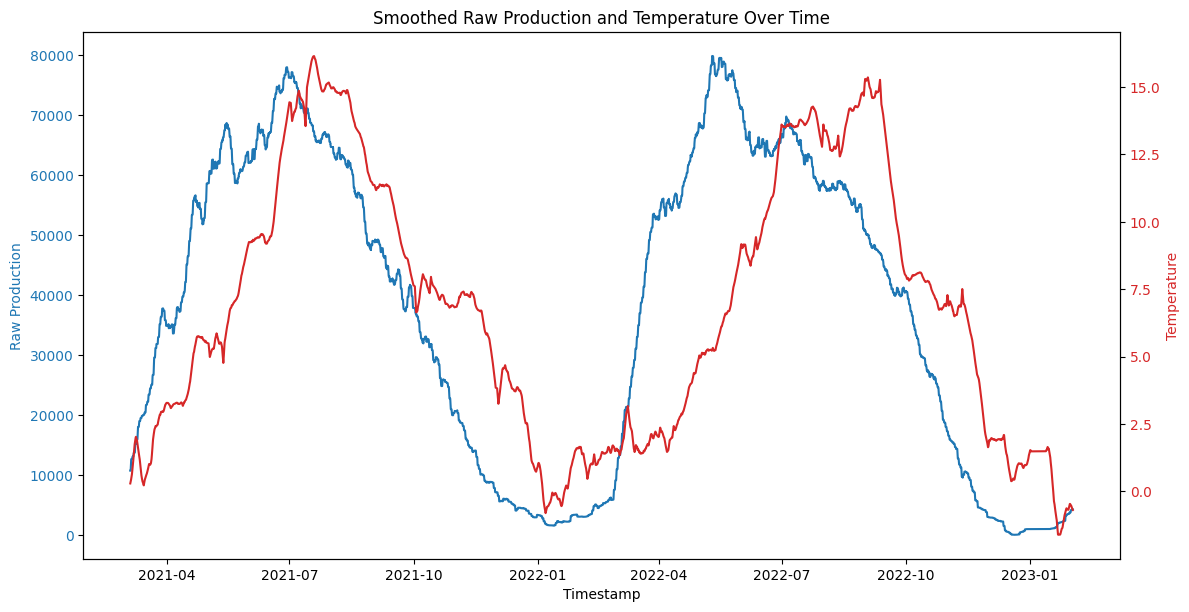

In [ ]:
# %%

# Plot the smoothed raw production and temperature data
#
# Apply rolling average to smooth lines (with a rough (24 hours * 30 days) monthly window size)

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot smoothed raw production data on primary y-axis
ax1.plot(data.index, data['raw'].rolling(window=24 * 30).mean(),
         color='tab:blue', label='Smoothed Raw Production')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Raw Production', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a secondary y-axis for smoothed temperature data
ax2 = ax1.twinx()
ax2.plot(data.index, data['temperature'].rolling(window=24 * 30).mean(),
         color='tab:red', label='Smoothed Temperature')
ax2.set_ylabel('Temperature', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.title('Smoothed Raw Production and Temperature Over Time')
plt.show()

In [ ]:
# %%

# Explore missing values
missing_values = data.isnull().sum()
missing_values

raw               0
temperature       0
modified1      1191
modified2      1375
modified3      1137
dtype: int64

In [ ]:
# %%

# Calculate percent of modified entries that is missing
total_cells = np.prod(data[['modified1', 'modified2', 'modified3']].shape)
total_missing = missing_values[['modified1', 'modified2', 'modified3']].sum()

percent_missing = (total_missing/total_cells) * 100
print(f"Percent of modified entries missing: {percent_missing.round(2)}%")

Percent of modified entries missing: 7.25%


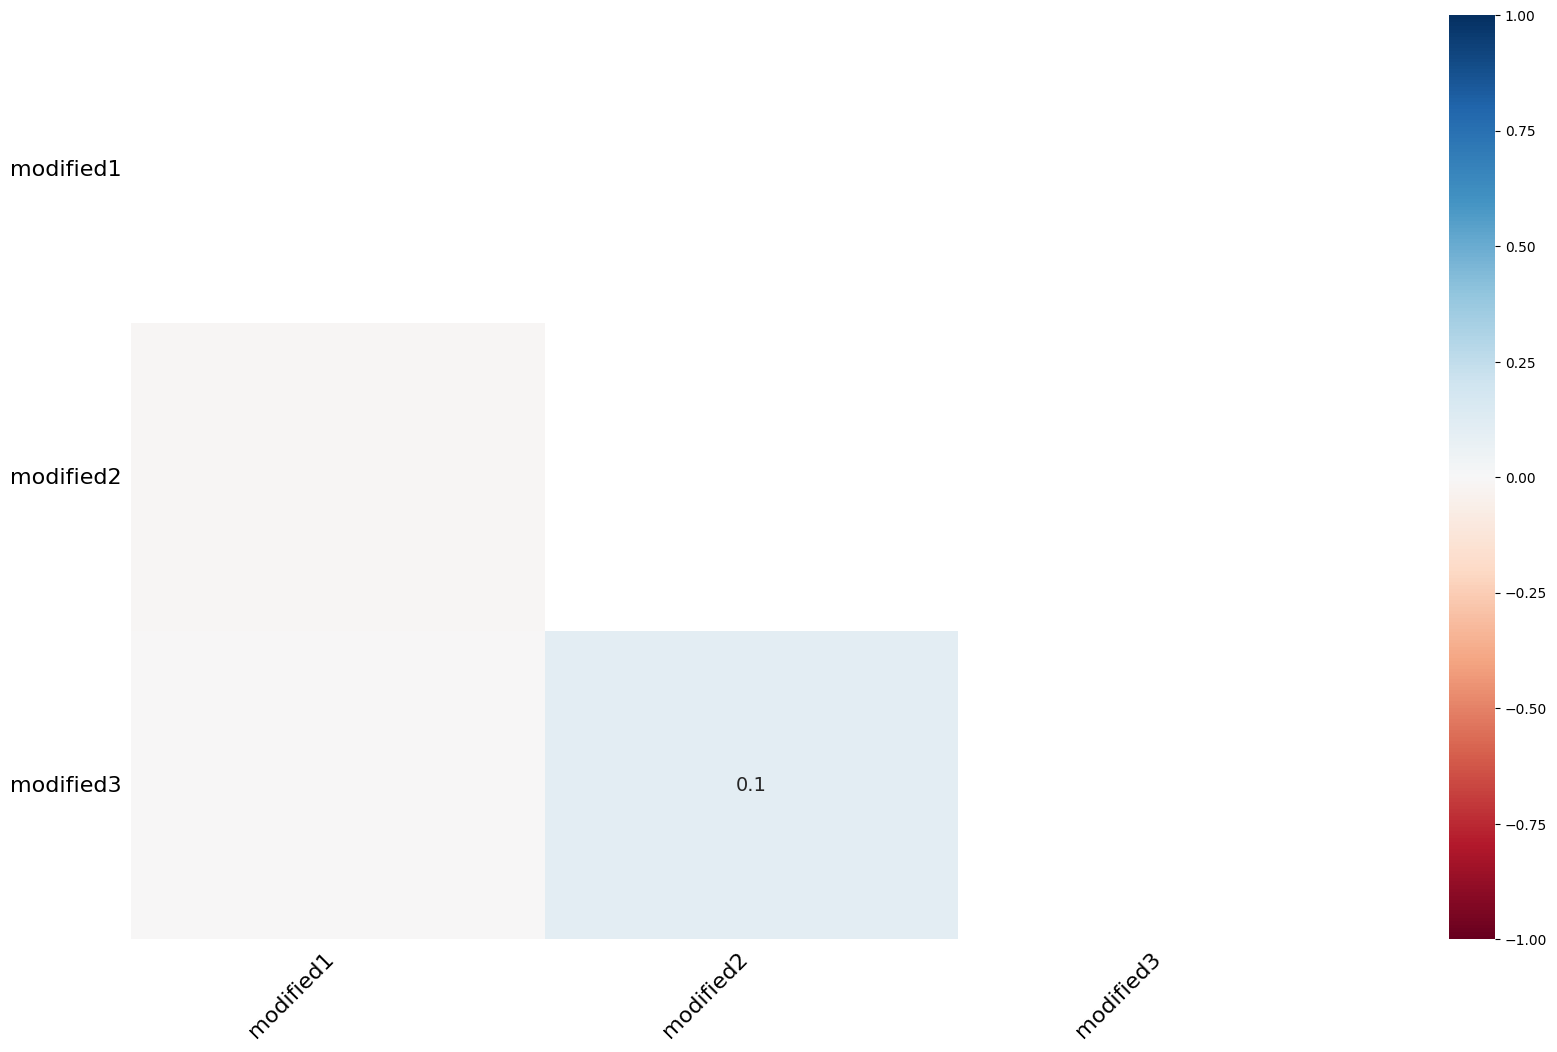

In [ ]:
# %%

# Visualize the missing values as a heatmap
msno.heatmap(data)
plt.show()

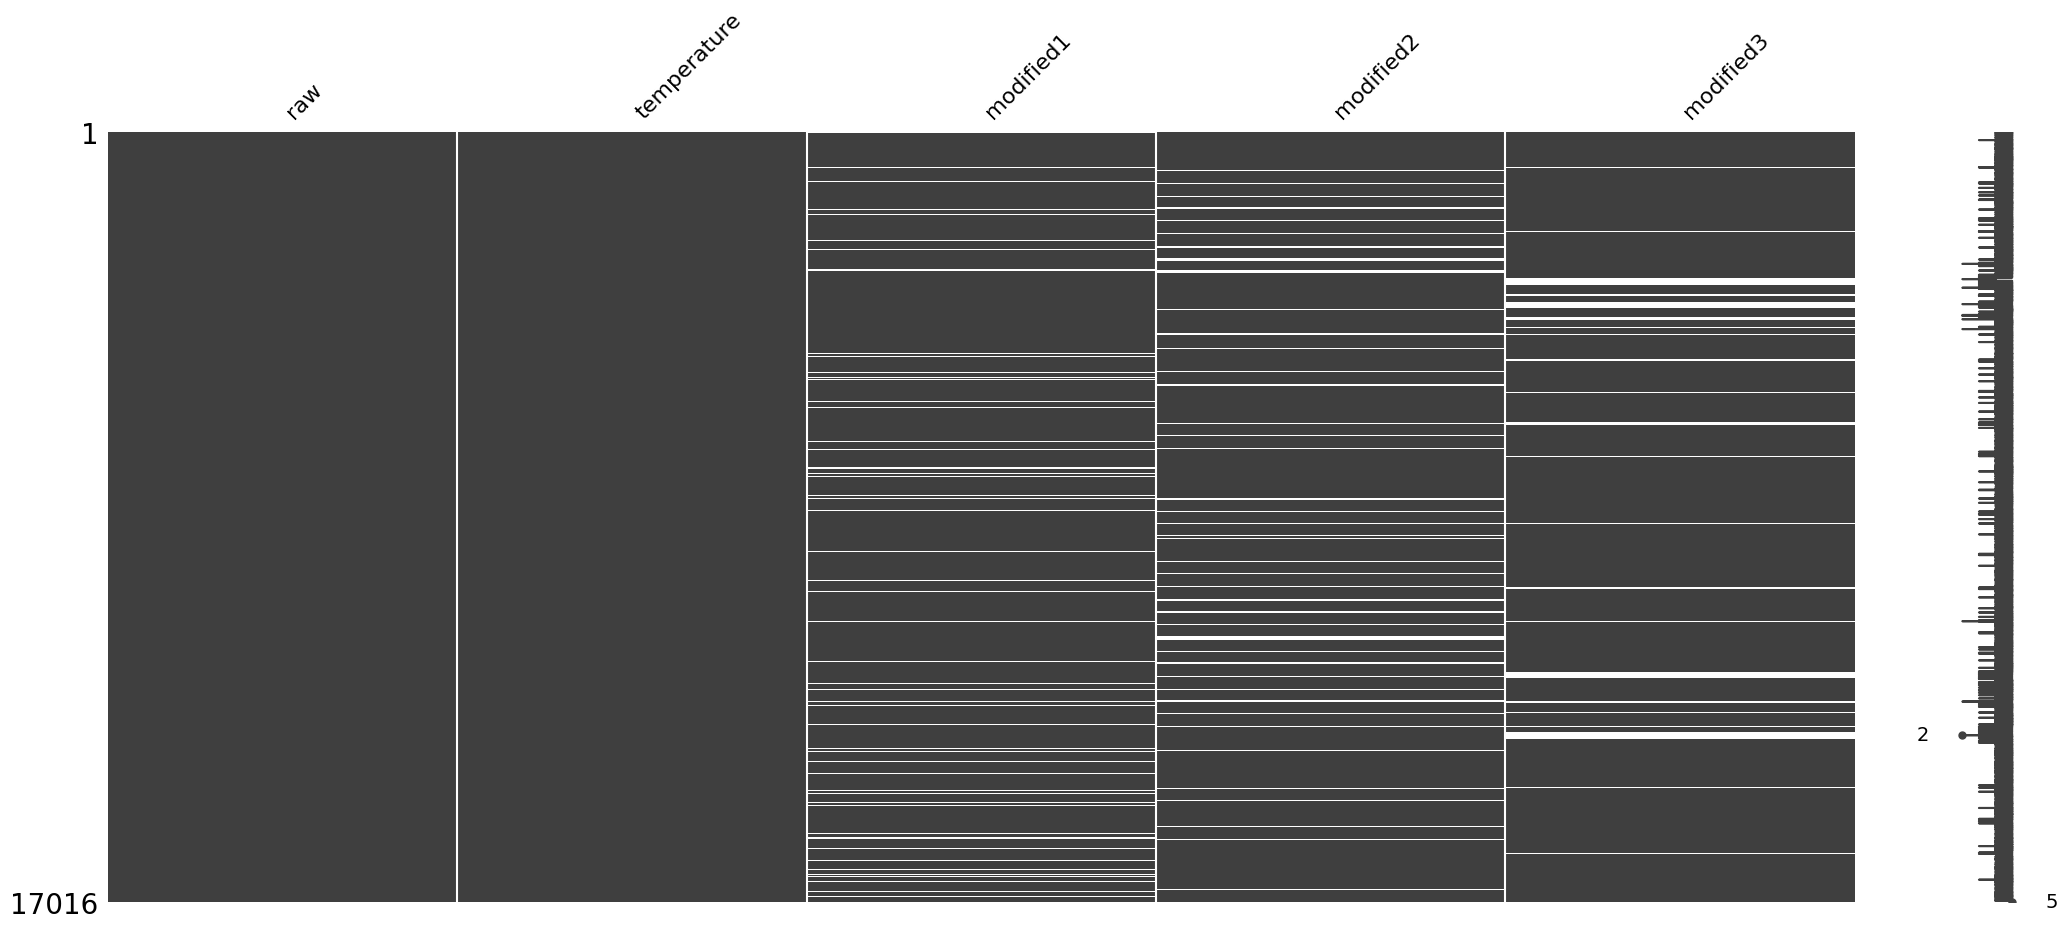

In [ ]:
# %%

# Visualize the missing values as a matrix
msno.matrix(data)
plt.show()

# %% [markdown]

 The timestamp, raw, temperature, and timestamp_unix columns have no missing values.

 The modified1, modified2, and modified3 columns show substantial missing data:
 1. modified1 has 1191 missing values.
 2. modified2 has 1375 missing values.
 3. modified3 has 1137 missing values.

 The percentage of missing values in the modified columns is approximately 7.25%.

 Visualizing the missing values using missingno does not reveal any specific patterns or correlations between the missing values in the modified columns.

In [ ]:
# %%

# Create new data frame with column indicating missingness (1 if missing, 0 otherwise) for each modified column
#
# as well as hour, day, month, and temperature for further analysis
data_missing = pd.DataFrame()
data_missing['modified1_missing'] = data['modified1'].isnull().astype(int)
data_missing['modified2_missing'] = data['modified2'].isnull().astype(int)
data_missing['modified3_missing'] = data['modified3'].isnull().astype(int)
data_missing['hour'] = data.index.hour
data_missing['day'] = data.index.day
data_missing['month'] = data.index.month
data_missing['weekday'] = data_missing.index.weekday

country_holidays = holidays.CountryHoliday('EE')
data_missing['is_holiday'] = data_missing.index.to_series().apply(
    lambda x: x in country_holidays)

data_missing['temperature'] = data['temperature']

data_missing.head(10)

,modified1_missing,modified2_missing,modified3_missing,hour,day,month,weekday,is_holiday,temperature
timestamp,,,,,,,,,
2021-02-02 00:00:00,0,0,0,0,2,2,1,False,-3.9
2021-02-02 01:00:00,0,0,0,1,2,2,1,False,-3.5
2021-02-02 02:00:00,0,0,0,2,2,2,1,False,-3.0
2021-02-02 03:00:00,0,0,0,3,2,2,1,False,-2.6
2021-02-02 04:00:00,0,0,0,4,2,2,1,False,-2.4
2021-02-02 05:00:00,0,0,0,5,2,2,1,False,-2.1
2021-02-02 06:00:00,1,0,0,6,2,2,1,False,-2.0
2021-02-02 07:00:00,0,0,0,7,2,2,1,False,-2.1
2021-02-02 08:00:00,0,0,0,8,2,2,1,False,-2.6


In [ ]:
# %%

# Check correlations between temperature and missingness indicators
correlation_with_temperature = data_missing.corr()
correlation_with_temperature

,modified1_missing,modified2_missing,modified3_missing,hour,day,month,weekday,is_holiday,temperature
modified1_missing,1.000000,-0.010345,-0.006071,9.483613e-04,-8.119527e-03,2.152855e-02,7.052037e-03,3.073409e-03,-0.009233
modified2_missing,-0.010345,1.000000,0.104595,-6.630507e-02,3.749123e-03,-2.606776e-02,2.632944e-03,1.697801e-03,0.116066
modified3_missing,-0.006071,0.104595,1.000000,4.458956e-02,2.076309e-02,2.525997e-02,-7.556411e-03,2.273642e-02,0.501724
hour,0.000948,-0.066305,0.044590,1.000000e+00,3.406801e-17,4.366289e-16,2.509063e-17,2.074886e-18,0.047183
day,-0.008120,0.003749,0.020763,3.406801e-17,1.000000e+00,-6.722101e-03,-1.207347e-02,2.896372e-02,0.073819
month,0.021529,-0.026068,0.025260,4.366289e-16,-6.722101e-03,1.000000e+00,-2.726223e-03,-4.095794e-03,0.078665
weekday,0.007052,0.002633,-0.007556,2.509063e-17,-1.207347e-02,-2.726223e-03,1.000000e+00,1.264532e-01,-0.007923
is_holiday,0.003073,0.001698,0.022736,2.074886e-18,2.896372e-02,-4.095794e-03,1.264532e-01,1.000000e+00,-0.050528
temperature,-0.009233,0.116066,0.501724,4.718348e-02,7.381889e-02,7.866458e-02,-7.922508e-03,-5.052844e-02,1.000000


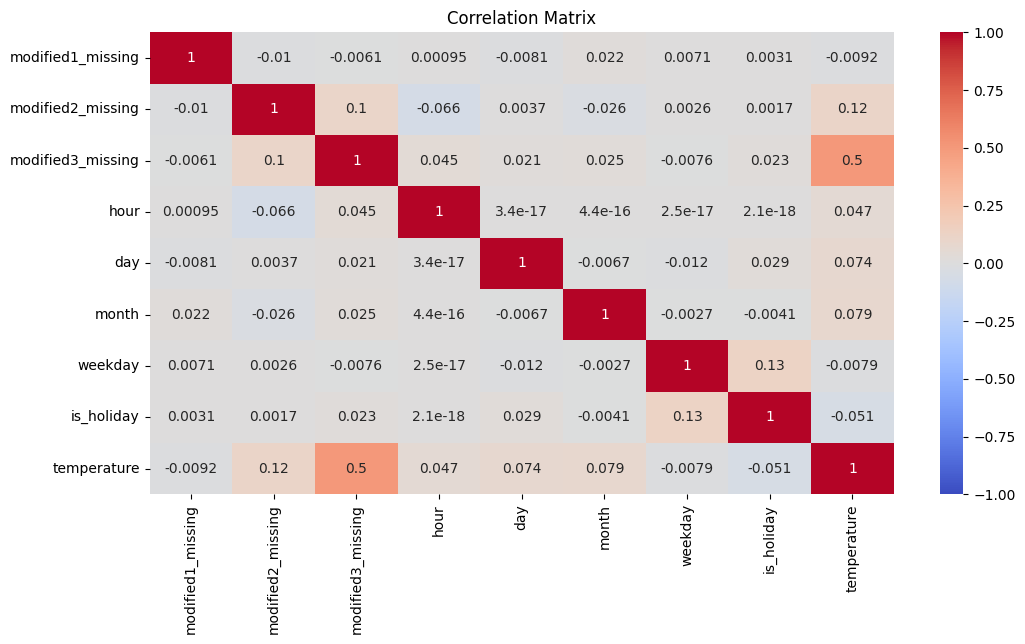

In [ ]:
# %%

# Plot correlation matrix as a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_with_temperature, annot=True,
            cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

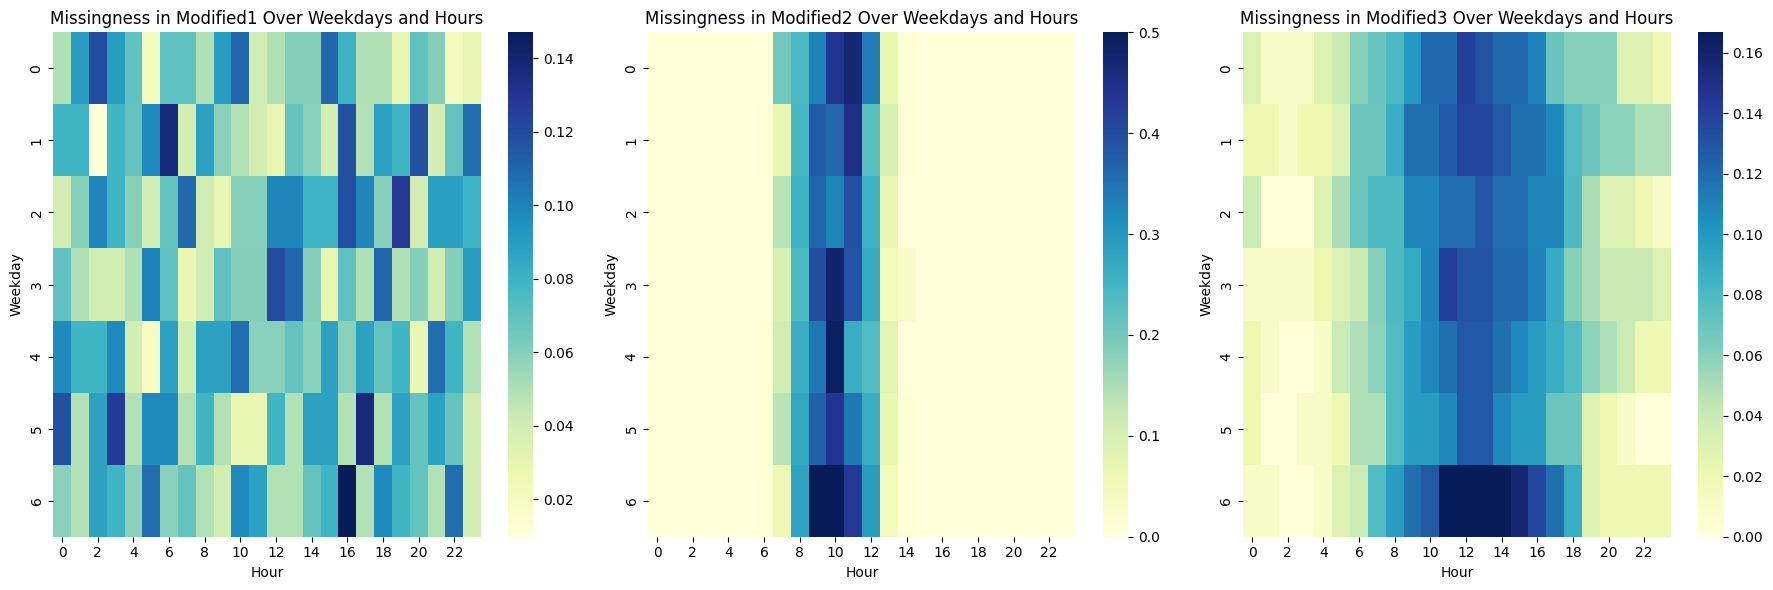

In [ ]:
# %%

# Create pivot table for missingness by weekday and hour
missingness_by_weekday_hour = data_missing.pivot_table(index='weekday', columns='hour',
                                                       values=[
                                                           'modified1_missing', 'modified2_missing', 'modified3_missing'],
                                                       aggfunc='mean')

# Plot heatmaps for each modified variable's missingness over weekdays and hours
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.heatmap(
    missingness_by_weekday_hour['modified1_missing'], cmap="YlGnBu", ax=axes[0])
axes[0].set_title('Missingness in Modified1 Over Weekdays and Hours')
axes[0].set_xlabel('Hour')
axes[0].set_ylabel('Weekday')

sns.heatmap(
    missingness_by_weekday_hour['modified2_missing'], cmap="YlGnBu", ax=axes[1])
axes[1].set_title('Missingness in Modified2 Over Weekdays and Hours')
axes[1].set_xlabel('Hour')
axes[1].set_ylabel('Weekday')

sns.heatmap(
    missingness_by_weekday_hour['modified3_missing'], cmap="YlGnBu", ax=axes[2])
axes[2].set_title('Missingness in Modified3 Over Weekdays and Hours')
axes[2].set_xlabel('Hour')
axes[2].set_ylabel('Weekday')

plt.tight_layout()
plt.show()

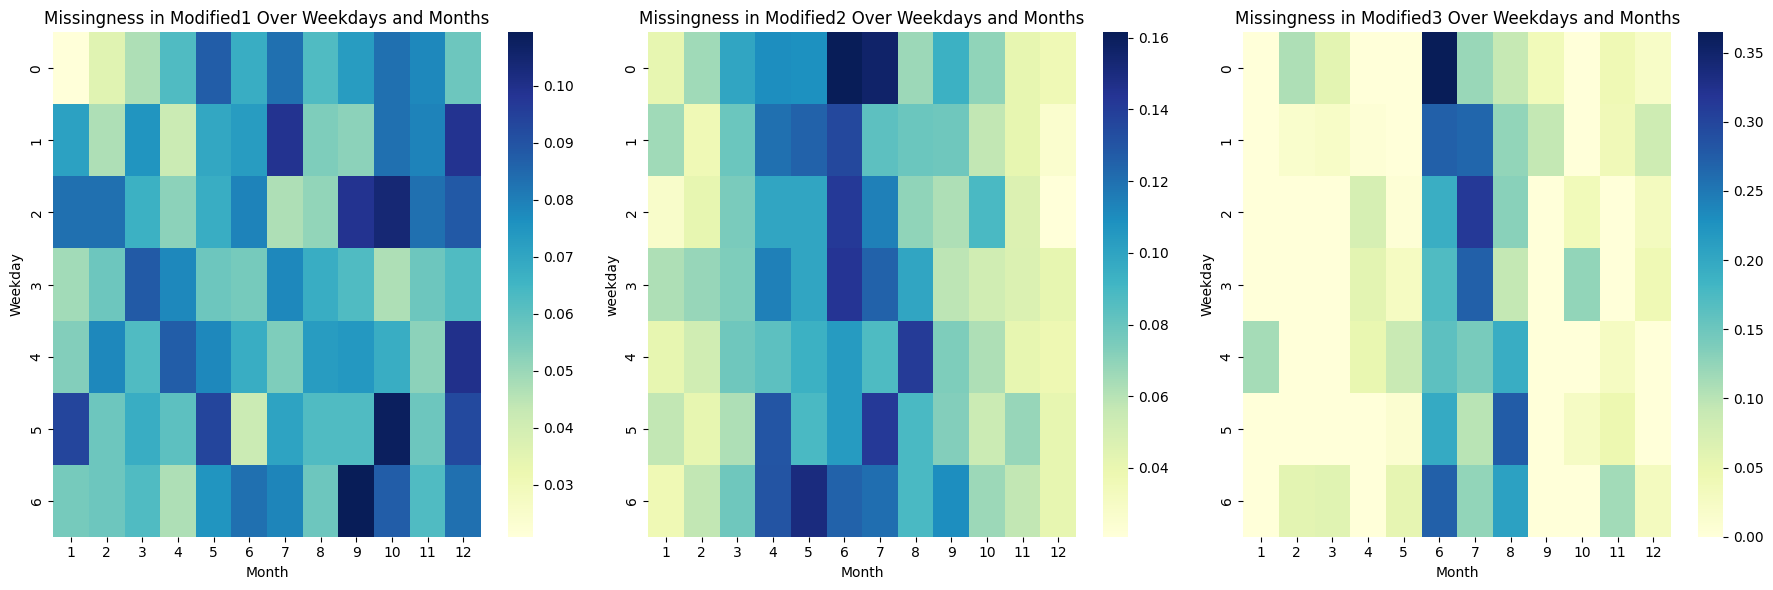

In [ ]:
# %%

# Create pivot table for missingness by weekday and month
missingness_by_weekday_month = data_missing.pivot_table(index='weekday', columns='month',
                                                        values=[
                                                            'modified1_missing', 'modified2_missing', 'modified3_missing'],
                                                        aggfunc='mean')

# Plot heatmaps for each modified variable's missingness over weekdays and months
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.heatmap(
    missingness_by_weekday_month['modified1_missing'], cmap="YlGnBu", ax=axes[0])
axes[0].set_title('Missingness in Modified1 Over Weekdays and Months')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Weekday')

sns.heatmap(
    missingness_by_weekday_month['modified2_missing'], cmap="YlGnBu", ax=axes[1])
axes[1].set_title('Missingness in Modified2 Over Weekdays and Months')
axes[1].set_xlabel('Month')

sns.heatmap(
    missingness_by_weekday_month['modified3_missing'], cmap="YlGnBu", ax=axes[2])
axes[2].set_title('Missingness in Modified3 Over Weekdays and Months')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Weekday')

plt.tight_layout()
plt.show()

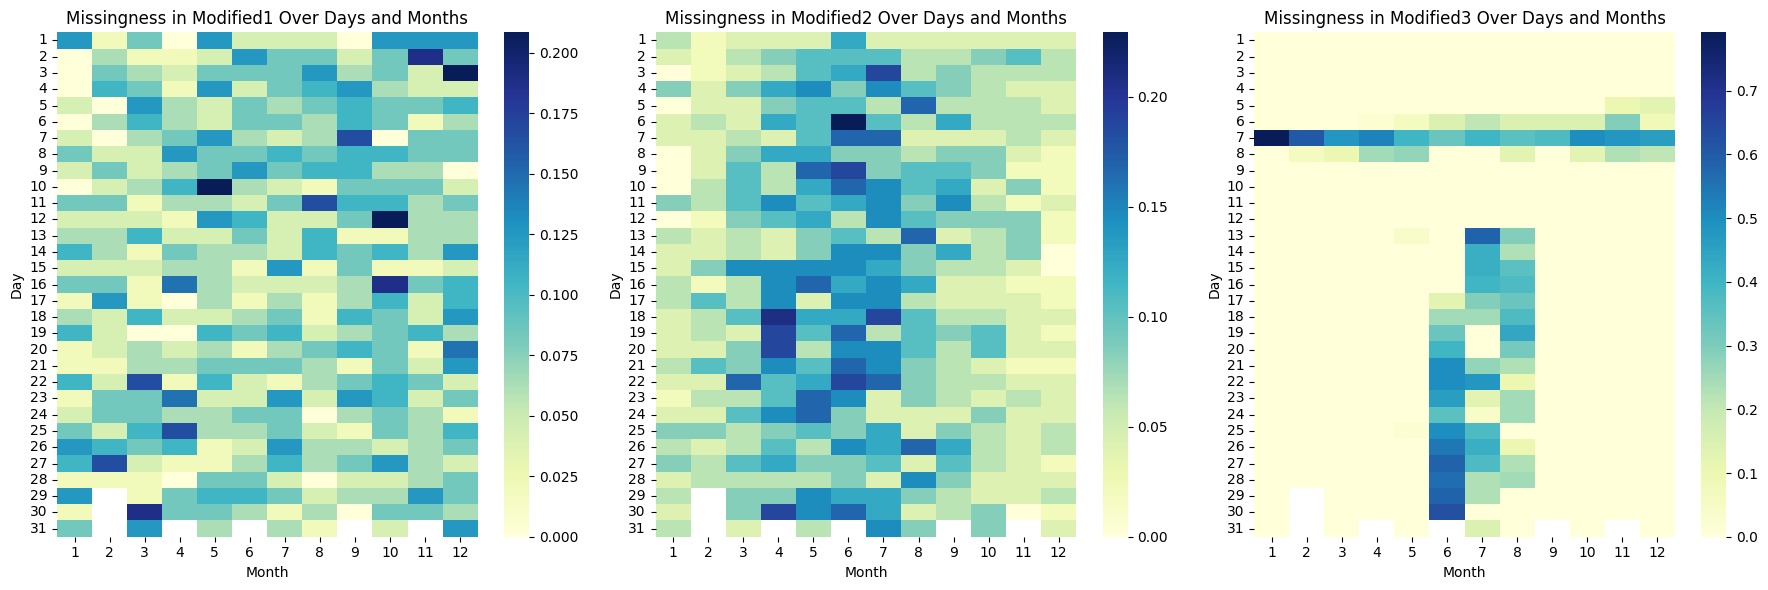

In [ ]:
# %%

# Create pivot table for missingness by day and month
missingness_by_day_month = data_missing.pivot_table(index='day', columns='month',
                                                    values=[
                                                        'modified1_missing', 'modified2_missing', 'modified3_missing'],
                                                    aggfunc='mean')

# Plot heatmaps for each modified variable's missingness over days and months
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.heatmap(
    missingness_by_day_month['modified1_missing'], cmap="YlGnBu", ax=axes[0])
axes[0].set_title('Missingness in Modified1 Over Days and Months')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Day')

sns.heatmap(
    missingness_by_day_month['modified2_missing'], cmap="YlGnBu", ax=axes[1])
axes[1].set_title('Missingness in Modified2 Over Days and Months')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Day')

sns.heatmap(
    missingness_by_day_month['modified3_missing'], cmap="YlGnBu", ax=axes[2])
axes[2].set_title('Missingness in Modified3 Over Days and Months')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Day')

plt.tight_layout()
plt.show()

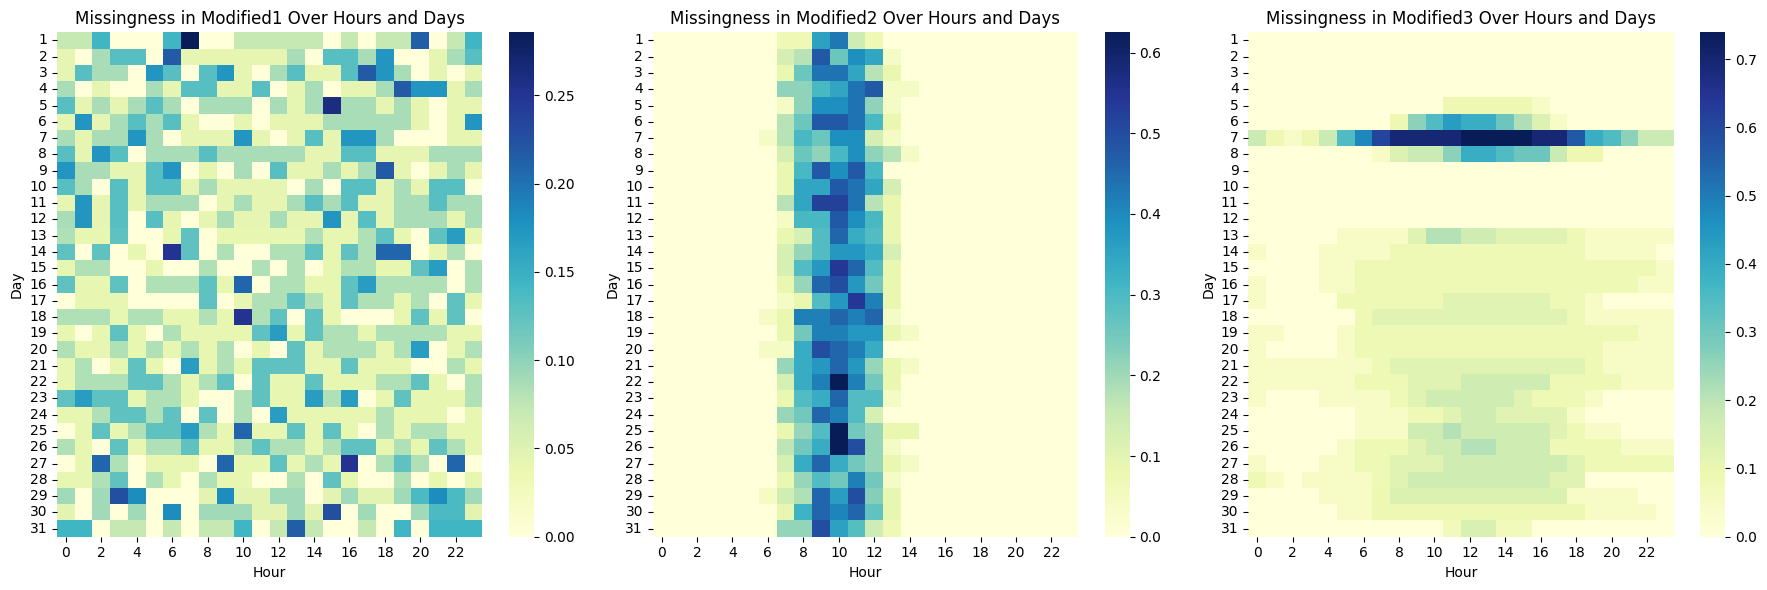

In [ ]:
# %%

# Create pivot table for missingness by hour and day
missingness_by_hour_day = data_missing.pivot_table(index='day', columns='hour',
                                                   values=[
                                                       'modified1_missing', 'modified2_missing', 'modified3_missing'],
                                                   aggfunc='mean')

# Plot heatmaps for each modified variable's missingness over days and hours
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.heatmap(
    missingness_by_hour_day['modified1_missing'], cmap="YlGnBu", ax=axes[0])
axes[0].set_title('Missingness in Modified1 Over Hours and Days')
axes[0].set_xlabel('Hour')
axes[0].set_ylabel('Day')

sns.heatmap(
    missingness_by_hour_day['modified2_missing'], cmap="YlGnBu", ax=axes[1])
axes[1].set_title('Missingness in Modified2 Over Hours and Days')
axes[1].set_xlabel('Hour')
axes[1].set_ylabel('Day')

sns.heatmap(
    missingness_by_hour_day['modified3_missing'], cmap="YlGnBu", ax=axes[2])
axes[2].set_title('Missingness in Modified3 Over Hours and Days')
axes[2].set_xlabel('Hour')
axes[2].set_ylabel('Day')

plt.tight_layout()
plt.show()

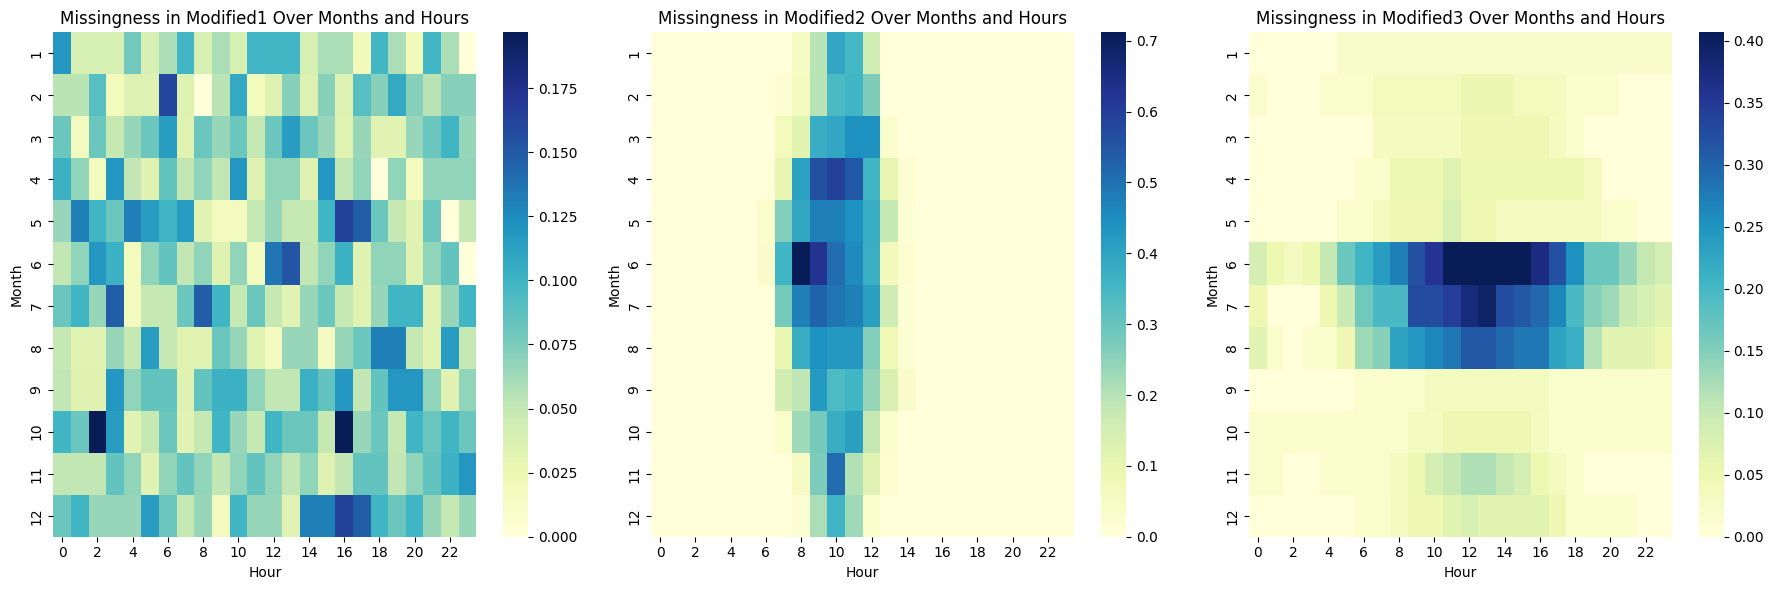

In [ ]:
# %%

# Create pivot table for missingness by month and hour
missingness_by_month_hour = data_missing.pivot_table(index='month', columns='hour',
                                                     values=[
                                                         'modified1_missing', 'modified2_missing', 'modified3_missing'],
                                                     aggfunc='mean')

# Plot heatmaps for each modified variable's missingness over months and hours
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.heatmap(
    missingness_by_month_hour['modified1_missing'], cmap="YlGnBu", ax=axes[0])
axes[0].set_title('Missingness in Modified1 Over Months and Hours')
axes[0].set_xlabel('Hour')
axes[0].set_ylabel('Month')

sns.heatmap(
    missingness_by_month_hour['modified2_missing'], cmap="YlGnBu", ax=axes[1])
axes[1].set_title('Missingness in Modified2 Over Months and Hours')
axes[1].set_xlabel('Hour')
axes[1].set_ylabel('Month')

sns.heatmap(
    missingness_by_month_hour['modified3_missing'], cmap="YlGnBu", ax=axes[2])
axes[2].set_title('Missingness in Modified3 Over Months and Hours')
axes[2].set_xlabel('Hour')
axes[2].set_ylabel('Month')

plt.tight_layout()
plt.show()

# %% [markdown]

 The missingness analysis of the `modified` columns reveals distinct patterns:
 1. **modified1_missing**: Missing values appear randomly with no observable patterns across time variables or temperature.
 2. **modified2_missing**: Missing data occurs exclusively between **7 AM and 12 PM** and is missing more during summer, indicating that missingness depends on the **hour of the day** and somewhat on the **month**.
 3. **modified3_missing**: Missingness is higher during the **summer months (June to August)** from **9 AM to 7 PM** peaking at 12AM when sun is commonly at high and correlates positively with **temperature** (correlation coefficient of **0.5**). Additionally, increased missingness is observed consistently specifically around the **7th day** of each month.

 **Conclusions**:
 - **modified1**: Missingness is **Missing Completely At Random (MCAR)** since it shows no relation to observed variables.
 - **modified2**: Missingness is **Missing At Random (MAR)** because it depends on the observed variable **hour**- and somewhat on **month**.
 - **modified3**: Missingness is **MAR** due to its dependence on **temperature** and **time variables**. However, the unexplained missingness on the **7th day** may suggest a separate **Missing At Random (MAR)** mechanism.

In [ ]:
# %%

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# %%

# Load the dataset
data = pd.read_csv('data/solar_232215.csv', delimiter=',', decimal='.')
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
data.set_index('timestamp', inplace=True)
data

,raw,temperature,modified1,modified2,modified3
timestamp,,,,,
2021-02-02 00:00:00,0.0,-3.9,0.0,0.0,0.0
2021-02-02 01:00:00,0.0,-3.5,0.0,0.0,0.0
2021-02-02 02:00:00,0.0,-3.0,0.0,0.0,0.0
2021-02-02 03:00:00,0.0,-2.6,0.0,0.0,0.0
2021-02-02 04:00:00,0.0,-2.4,0.0,0.0,0.0
...,...,...,...,...,...
2023-02-01 19:00:00,0.0,0.0,0.0,0.0,0.0
2023-02-01 20:00:00,0.0,0.1,0.0,0.0,0.0
2023-02-01 21:00:00,0.0,0.1,0.0,0.0,0.0


# %% [markdown]

 Since `modified1` has missing values missing completely at random (MCAR), three methods were used to handle the missing data:
 1. **Deletion**: Removed rows with missing values in `modified1`, resulting in a reduced dataset size.
 2. **Univariate Imputation (Median)**: Filled missing values in `modified1` using the median of the column.
 3. **Multivariate Imputation (KNN)**: Imputed `modified1` values based on `temperature`, utilizing relationships between variables.
 Imputation Quality Comparison

In [ ]:
# %%

# Approach 1: Deletion - Remove rows with missing 'modified1'
data_deletion = data.dropna(subset=['modified1']).copy()
print(f"Original data size: {data.shape[0]} rows")
print(f"After deletion: {data_deletion.shape[0]} rows")
print(f"Number of rows removed: {data.shape[0] - data_deletion.shape[0]}")

Original data size: 17016 rows
After deletion: 15825 rows
Number of rows removed: 1191


In [ ]:
# %%

# Approach 2: Univariate Imputation (Median)
median_imputer = SimpleImputer(strategy='median')
data_univariate = data.copy()
data_univariate['modified1'] = median_imputer.fit_transform(
    data_univariate[['modified1']])

In [ ]:
# %%

# Approach 3: Multivariate Imputation (KNN)
knn_imputer = KNNImputer(n_neighbors=5)
data_multivariate = data.copy()
data_multivariate[['modified1', 'temperature']] = knn_imputer.fit_transform(
    data[['modified1', 'temperature']]
)

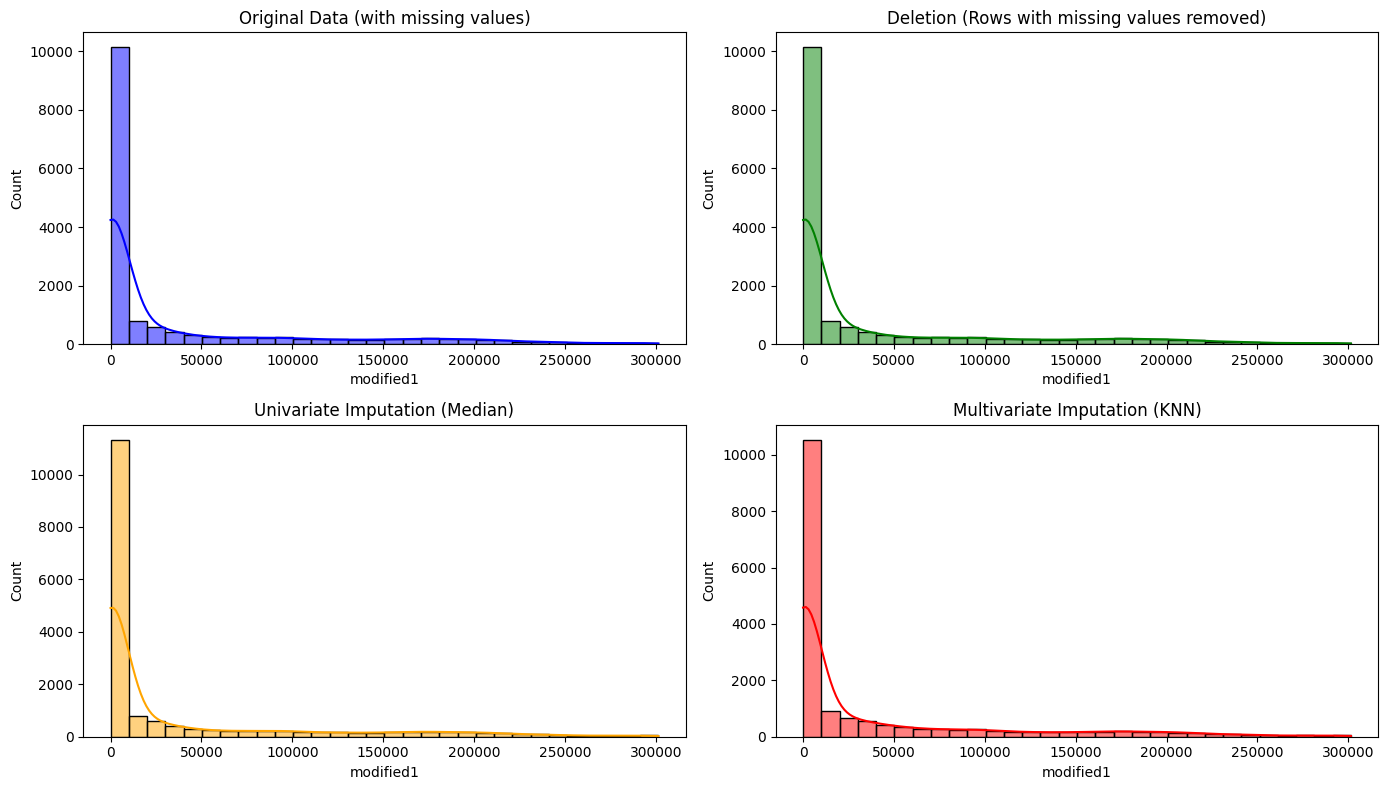

In [ ]:
# %%

# Visualize the distribution of 'modified1' for each approach
plt.figure(figsize=(14, 8))

# Original data
plt.subplot(2, 2, 1)
sns.histplot(data['modified1'], bins=30, kde=True, color='blue')
plt.title("Original Data (with missing values)")

# Deletion approach
plt.subplot(2, 2, 2)
sns.histplot(data_deletion['modified1'], bins=30, kde=True, color='green')
plt.title("Deletion (Rows with missing values removed)")

# Univariate Imputation
plt.subplot(2, 2, 3)
sns.histplot(data_univariate['modified1'], bins=30, kde=True, color='orange')
plt.title("Univariate Imputation (Median)")

# Multivariate Imputation
plt.subplot(2, 2, 4)
sns.histplot(data_multivariate['modified1'], bins=30, kde=True, color='red')
plt.title("Multivariate Imputation (KNN)")

plt.tight_layout()
plt.show()

In [ ]:
# %%

# Evaluate the imputation quality
missing_indices = data[data['modified1'].isna()].index

# Initialize a dictionary to store metrics
metrics_on_missing = {}

# Univariate Imputation
mse_uni = mean_squared_error(
    data.loc[missing_indices, 'raw'],
    data_univariate.loc[missing_indices, 'modified1']
)
mae_uni = mean_absolute_error(
    data.loc[missing_indices, 'raw'],
    data_univariate.loc[missing_indices, 'modified1']
)
std_err_uni = np.std(
    data_univariate.loc[missing_indices, 'modified1'] -
    data.loc[missing_indices, 'raw']
) / np.sqrt(len(missing_indices))

metrics_on_missing['Univariate Imputation'] = {
    'MSE': mse_uni,
    'MAE': mae_uni,
    'Standard Error': std_err_uni
}

# Multivariate Imputation
mse_multi = mean_squared_error(
    data.loc[missing_indices, 'raw'],
    data_multivariate.loc[missing_indices, 'modified1']
)
mae_multi = mean_absolute_error(
    data.loc[missing_indices, 'raw'],
    data_multivariate.loc[missing_indices, 'modified1']
)
std_err_multi = np.std(
    data_multivariate.loc[missing_indices, 'modified1'] -
    data.loc[missing_indices, 'raw']
) / np.sqrt(len(missing_indices))

metrics_on_missing['Multivariate Imputation'] = {
    'MSE': mse_multi,
    'MAE': mae_multi,
    'Standard Error': std_err_multi
}

# Convert metrics into a DataFrame
metrics_df = pd.DataFrame(metrics_on_missing).T
metrics_df.columns = [
    "Mean Squared Error (MSE)", "Mean Absolute Error (MAE)", "Standard Error"
]

metrics_df

,Mean Squared Error (MSE),Mean Absolute Error (MAE),Standard Error
Univariate Imputation,5.522092e+09,35595.197070,1890.156017
Multivariate Imputation,4.664911e+09,45406.445071,1978.625066


# %% [markdown]

 The table below compares each imputation method against the `raw` data as the reference baseline. The performance metrics used are:

 - **Mean Squared Error (MSE)**: Measures the average squared difference between imputed values and `raw` values. Lower values indicate better accuracy.
 - **Mean Absolute Error (MAE)**: Represents the average absolute difference between imputed and `raw` values. Lower values indicate better fit.
 - **Standard Error**: Assesses the variability of the difference between imputed values and `raw` values. Lower values suggest greater stability.

 | Imputation Method         | Mean Squared Error (MSE) | Mean Absolute Error (MAE) | Standard Error |
 |---------------------------|--------------------------|---------------------------|----------------|
 | **Univariate Imputation** | 5.522092e+09 | 35595.197070 | 1890.156017 |
 | **Multivariate Imputation** | 4.664911e+09 | 45406.445071 | 1978.625066 |

 - **Multivariate Imputation (KNN)** resulted in a lower MSE, suggesting better overall accuracy in capturing the variability of the data compared to **Univariate Imputation (Median)**.
 - However, **Univariate Imputation (Median)** achieved a lower MAE, indicating that on average, its imputed values were closer to the `raw` values.
 - The **Standard Error** was slightly lower for **Univariate Imputation**, indicating slightly less variability in the errors.

 In summary, both imputation methods have their merits. **Multivariate Imputation (KNN)** better captures the overall variability in the data (lower MSE), while **Univariate Imputation (Median)** provides imputed values that are closer on average to the `raw` values (lower MAE). Depending on the specific requirements of the analysis, one method may be preferred over the other.

In [ ]:
# %%

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot, boxcox

In [ ]:
# %%

# Load the dataset
data = pd.read_csv('data/solar_232215.csv', delimiter=',', decimal='.')
# Since we are working with raw data, delete the modified1, modified2, and modified3 columns
data.drop(['modified1', 'modified2', 'modified3'],
          axis=1, inplace=True, errors='ignore')
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
data.set_index('timestamp', inplace=True)
data

,raw,temperature
timestamp,,
2021-02-02 00:00:00,0.0,-3.9
2021-02-02 01:00:00,0.0,-3.5
2021-02-02 02:00:00,0.0,-3.0
2021-02-02 03:00:00,0.0,-2.6
2021-02-02 04:00:00,0.0,-2.4
...,...,...
2023-02-01 19:00:00,0.0,0.0
2023-02-01 20:00:00,0.0,0.1
2023-02-01 21:00:00,0.0,0.1


In [ ]:
# %%

# Data Description
data_description = data.describe()
data_description

,raw,temperature
count,17016.000000,17016.000000
mean,36912.094888,6.609191
std,66907.410347,9.292033
min,0.000000,-24.500000
25%,0.000000,-0.200000
50%,0.000000,6.400000
75%,38258.015000,13.400000
max,301630.010000,30.100000


<Figure size 1400x600 with 0 Axes>

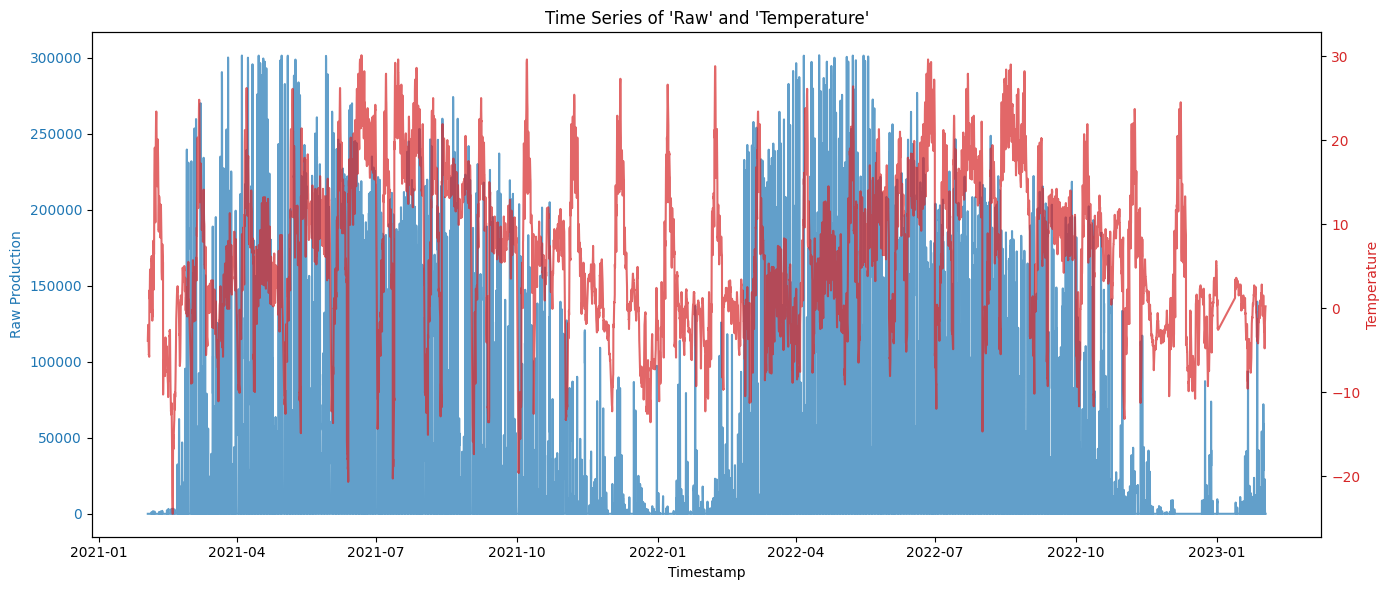

In [ ]:
# %%

# Time Series Plot with Dual Y-Axes
plt.figure(figsize=(14, 6))
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot for "raw" with primary y-axis
ax1.plot(data.index, data['raw'], label='Raw', color='tab:blue', alpha=0.7)
ax1.set_xlabel("Timestamp")
ax1.set_ylabel("Raw Production", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Secondary y-axis for "temperature"
ax2 = ax1.twinx()
ax2.plot(data.index, data['temperature'],
         label='Temperature', color='tab:red', alpha=0.7)
ax2.set_ylabel("Temperature", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title("Time Series of 'Raw' and 'Temperature'")
fig.tight_layout()
plt.show()

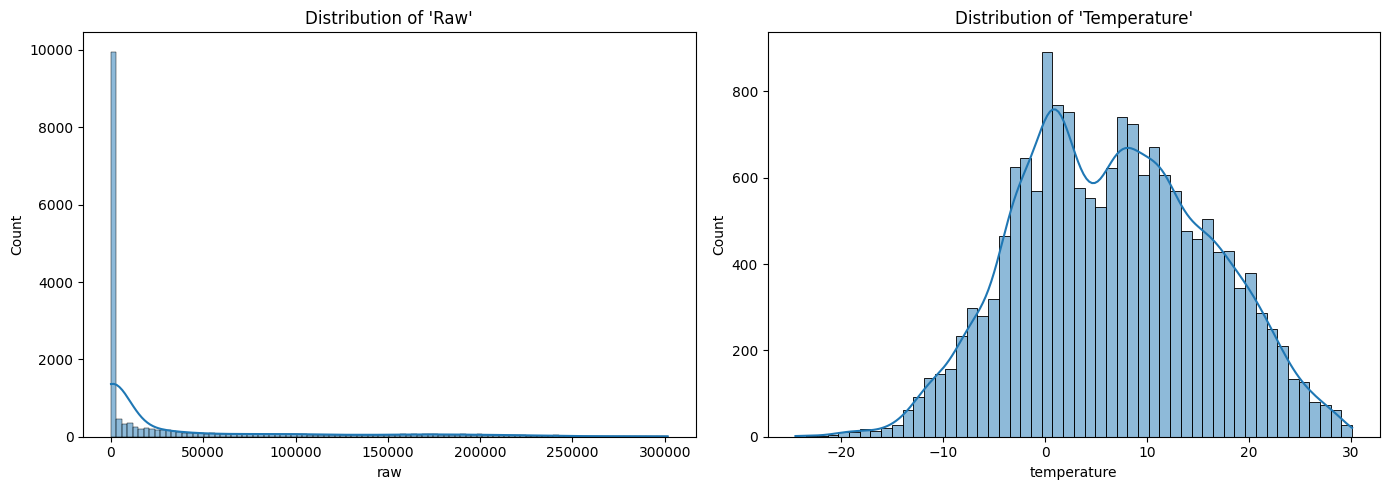

In [ ]:
# %%

# Histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(data['raw'], kde=True, ax=axes[0])
axes[0].set_title("Distribution of 'Raw'")
sns.histplot(data['temperature'], kde=True, ax=axes[1])
axes[1].set_title("Distribution of 'Temperature'")
plt.tight_layout()
plt.show()

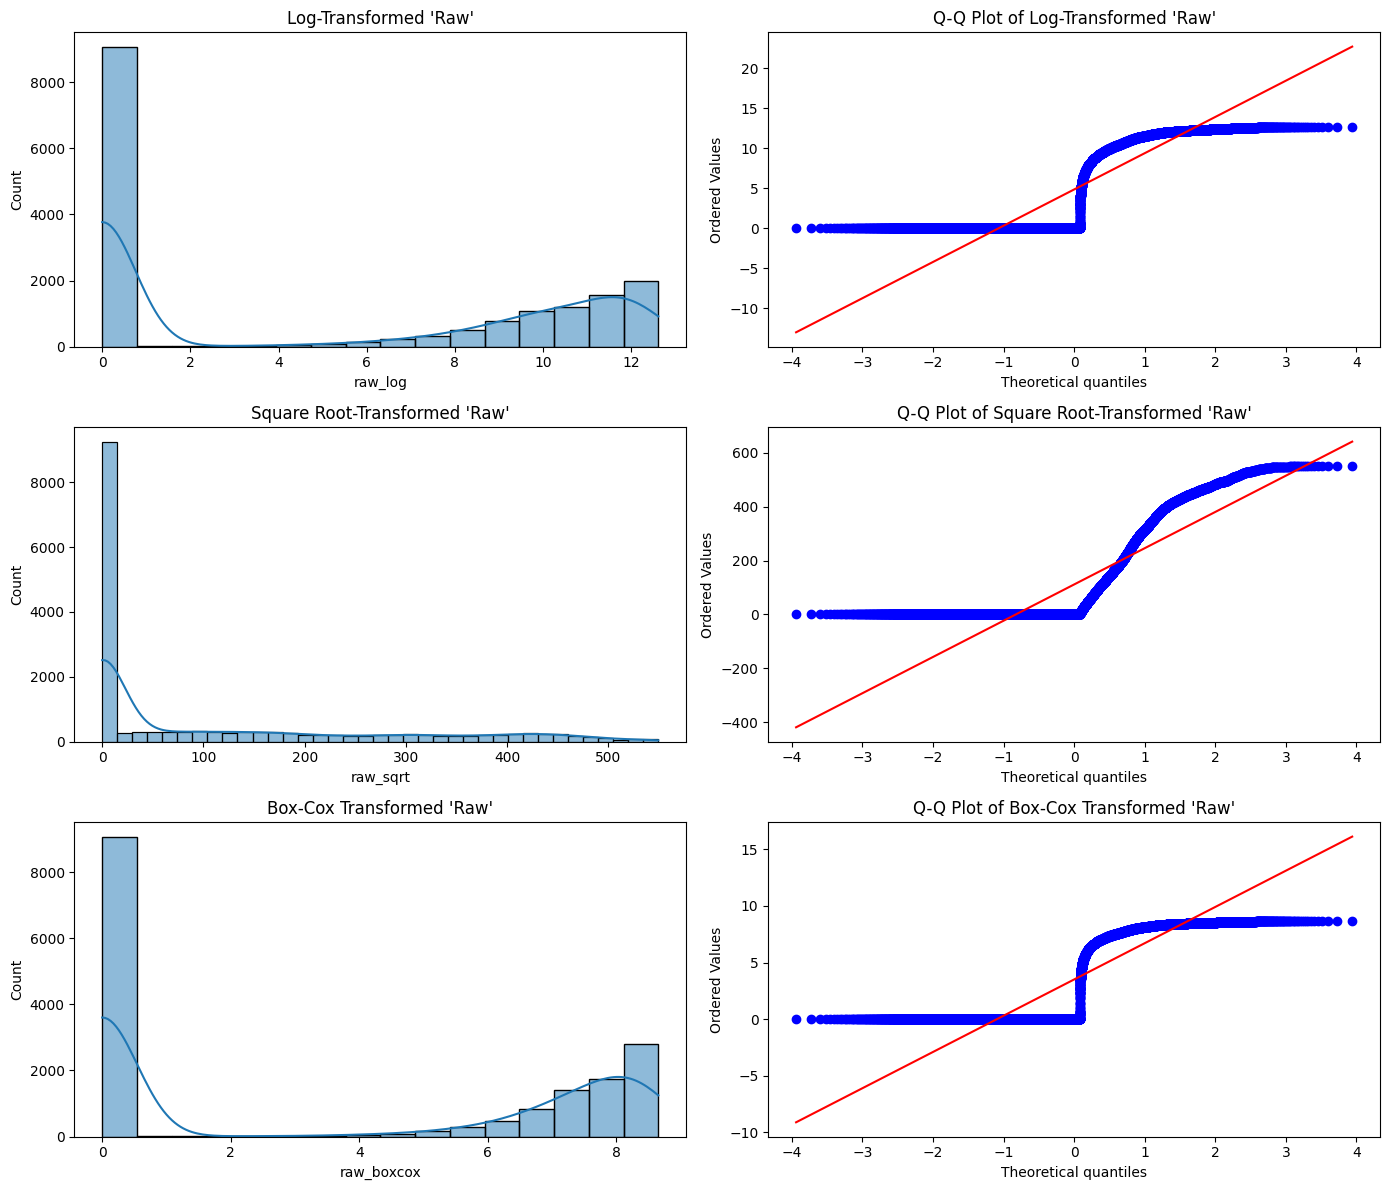

In [ ]:
# %%

# Transformations for "Raw" - Histogram and Q-Q Plot
# Log transformation with small constant for zeros, Square root, and Box-Cox
data['raw_log'] = np.log1p(data['raw'])
data['raw_sqrt'] = np.sqrt(data['raw'])
data['raw_boxcox'], fitted_lambda = boxcox(
    data['raw'] + 1)  # Box-Cox with offset to handle zero

fig, axes = plt.subplots(3, 2, figsize=(14, 12))
sns.histplot(data['raw_log'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Log-Transformed 'Raw'")
probplot(data['raw_log'], dist="norm", plot=axes[0, 1])
axes[0, 1].set_title("Q-Q Plot of Log-Transformed 'Raw'")

sns.histplot(data['raw_sqrt'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title("Square Root-Transformed 'Raw'")
probplot(data['raw_sqrt'], dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of Square Root-Transformed 'Raw'")

sns.histplot(data['raw_boxcox'], kde=True, ax=axes[2, 0])
axes[2, 0].set_title("Box-Cox Transformed 'Raw'")
probplot(data['raw_boxcox'], dist="norm", plot=axes[2, 1])
axes[2, 1].set_title("Q-Q Plot of Box-Cox Transformed 'Raw'")

plt.tight_layout()
plt.show()

# %% [markdown]

 None of the transformations significantly improved the distribution of 'raw'.

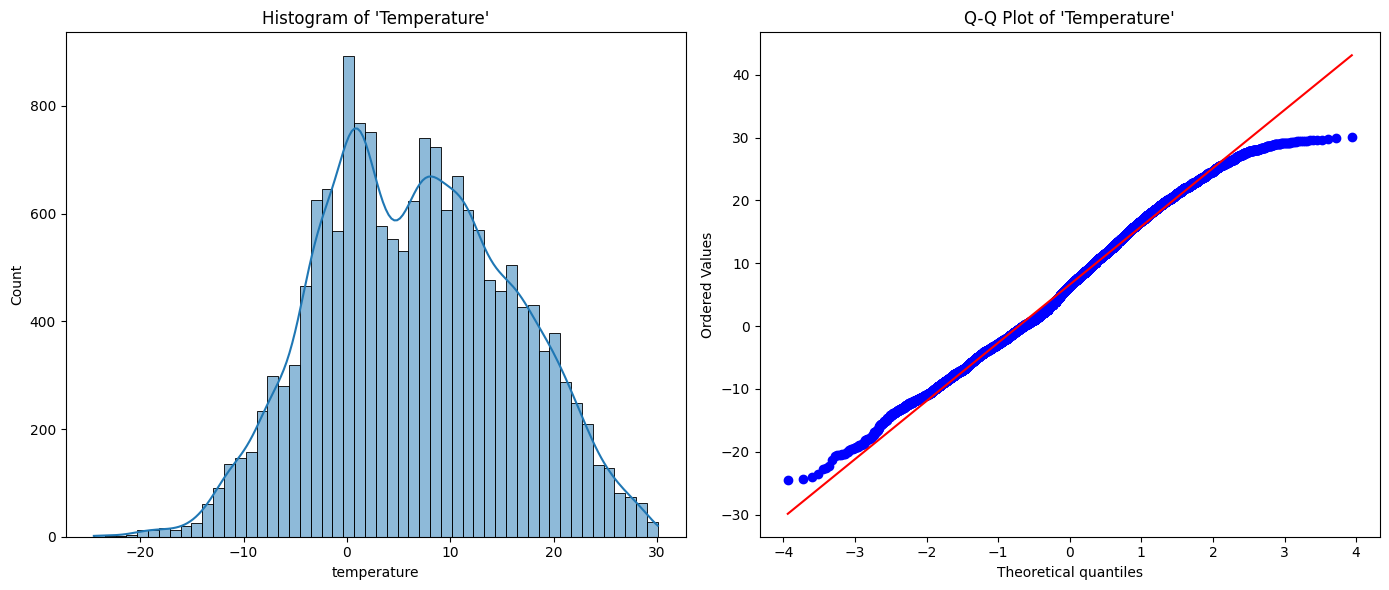

In [ ]:
# %%

# Temperature - Histogram and Q-Q Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.histplot(data['temperature'], kde=True, ax=axes[0])
axes[0].set_title("Histogram of 'Temperature'")
probplot(data['temperature'], dist="norm", plot=axes[1])
axes[1].set_title("Q-Q Plot of 'Temperature'")
plt.tight_layout()
plt.show()

# %% [markdown]

 The temperature distribution is sufficiently symmetric. No transformation is necessary.

In [ ]:
# %%

# Checking for duplicate timestamps
duplicate_timestamps = data.index.duplicated().sum()
duplicate_timestamps

np.int64(0)

# %% [markdown]

 There are no duplicate timestamps in the dataset.

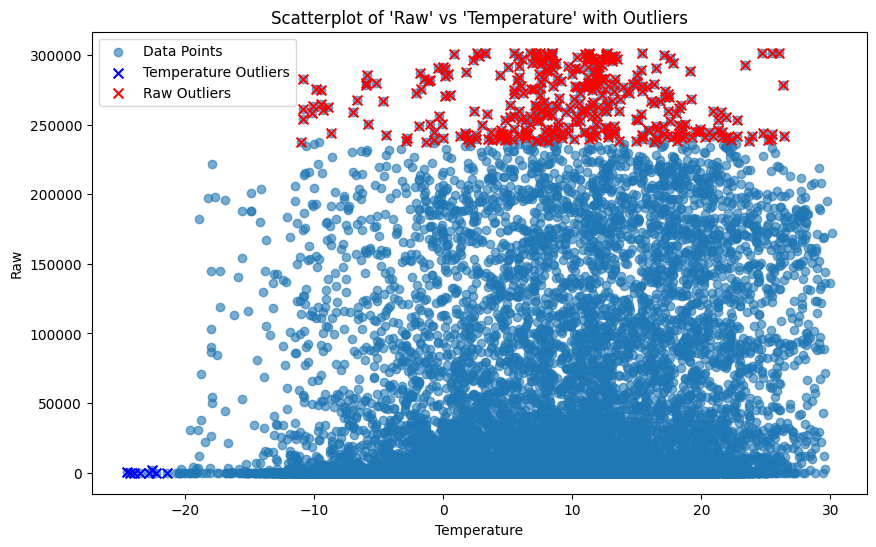

In [ ]:
# %%

# Scatterplot of 'Raw' vs 'Temperature' with Outliers
# Calculating Z-Scores to identify outliers
data['temp_z_score'] = (data['temperature'] -
                        data['temperature'].mean()) / data['temperature'].std()
data['raw_z_score'] = (data['raw'] - data['raw'].mean()) / data['raw'].std()

# Identify points where Z-score exceeds a threshold (e.g., |Z| > 3)
temp_outliers = data[data['temp_z_score'].abs() > 3]
raw_outliers = data[data['raw_z_score'].abs() > 3]

# Plotting the scatterplot with marked outliers
plt.figure(figsize=(10, 6))
plt.scatter(data['temperature'], data['raw'], alpha=0.6, label='Data Points')
plt.scatter(temp_outliers['temperature'], temp_outliers['raw'],
            color='blue', label='Temperature Outliers', s=50, marker='x')
plt.scatter(raw_outliers['temperature'], raw_outliers['raw'],
            color='red', label='Raw Outliers', s=50, marker='x')
plt.title("Scatterplot of 'Raw' vs 'Temperature' with Outliers")
plt.xlabel("Temperature")
plt.ylabel("Raw")
plt.legend()
plt.show()

# %% [markdown]

 There are many outliers somehow. It might make sense to analyze daily averages to identify whether these outliers are consistent across days.

In [ ]:
# %%

daily_data = data.resample('D').mean()
daily_data

,raw,temperature,raw_log,raw_sqrt,raw_boxcox,temp_z_score,raw_z_score
timestamp,,,,,,,
2021-02-02,0.000000,-4.058333,0.000000,0.000000,0.000000,-1.148029,-0.551689
2021-02-03,0.000000,2.075000,0.000000,0.000000,0.000000,-0.487965,-0.551689
2021-02-04,46.591667,2.325000,0.292515,1.393312,0.235579,-0.461061,-0.550993
2021-02-05,263.025833,4.083333,1.854145,8.094186,1.512756,-0.271830,-0.547758
2021-02-06,236.162500,14.275000,1.627236,7.247500,1.323804,0.824987,-0.548159
...,...,...,...,...,...,...,...
2023-01-28,5428.475833,-1.858333,2.941760,37.390964,2.220555,-0.911267,-0.470555
2023-01-29,2687.852500,0.037500,2.782449,26.765828,2.139831,-0.707239,-0.511516
2023-01-30,7023.851667,1.262500,3.106298,42.721414,2.327888,-0.575406,-0.446711


<Figure size 1400x600 with 0 Axes>

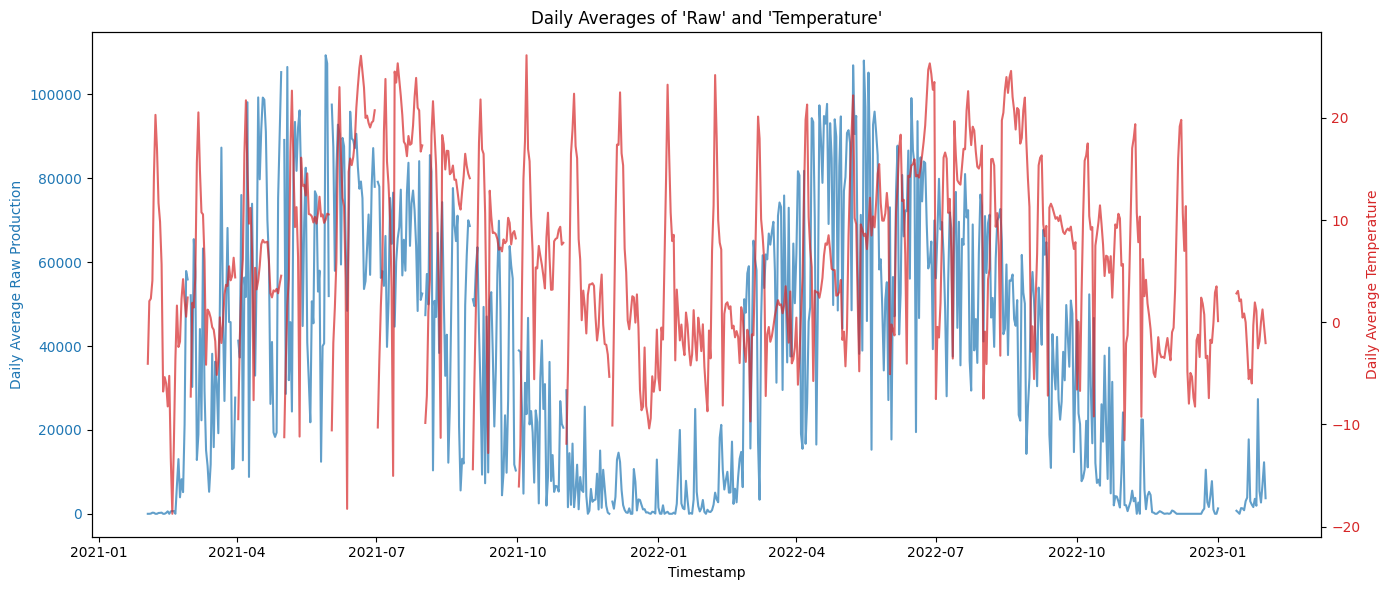

In [ ]:
# %%

# Time Series Plot of Daily Averages with Dual Y-Axes
plt.figure(figsize=(14, 6))
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot for daily average "raw" on the primary y-axis
ax1.plot(daily_data.index,
         daily_data['raw'], label='Daily Average Raw', color='tab:blue', alpha=0.7)
ax1.set_xlabel("Timestamp")
ax1.set_ylabel("Daily Average Raw Production", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Secondary y-axis for daily average "temperature"
ax2 = ax1.twinx()
ax2.plot(daily_data.index, daily_data['temperature'],
         label='Daily Average Temperature', color='tab:red', alpha=0.7)
ax2.set_ylabel("Daily Average Temperature", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title("Daily Averages of 'Raw' and 'Temperature'")
fig.tight_layout()
plt.show()

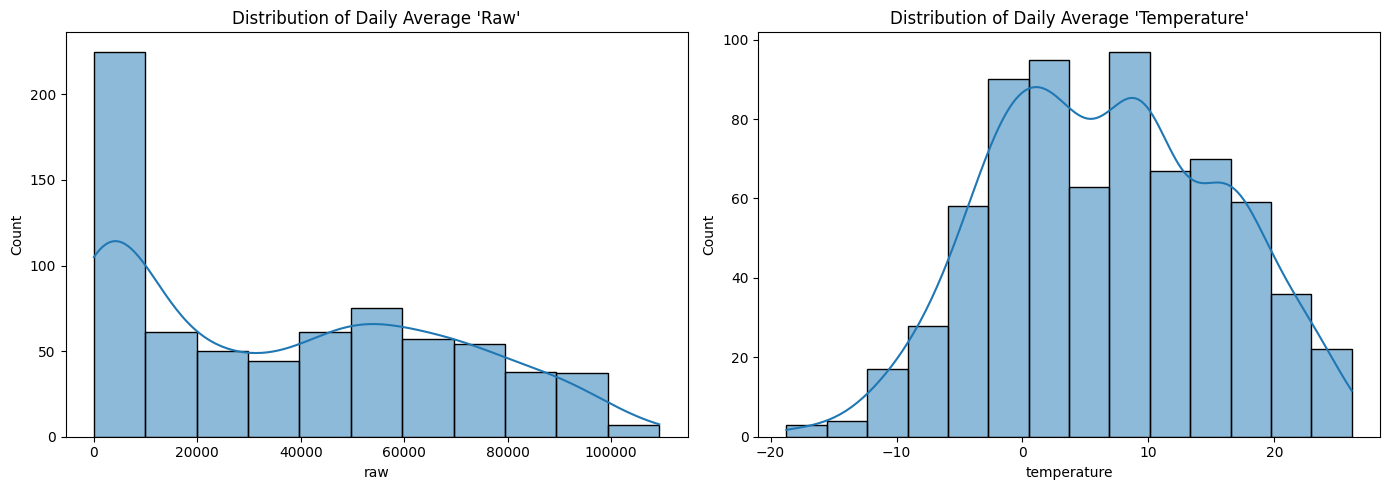

In [ ]:
# %%

# Histograms of Daily Averages
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(daily_data['raw'], kde=True, ax=axes[0])
axes[0].set_title("Distribution of Daily Average 'Raw'")
sns.histplot(daily_data['temperature'], kde=True, ax=axes[1])
axes[1].set_title("Distribution of Daily Average 'Temperature'")
plt.tight_layout()
plt.show()

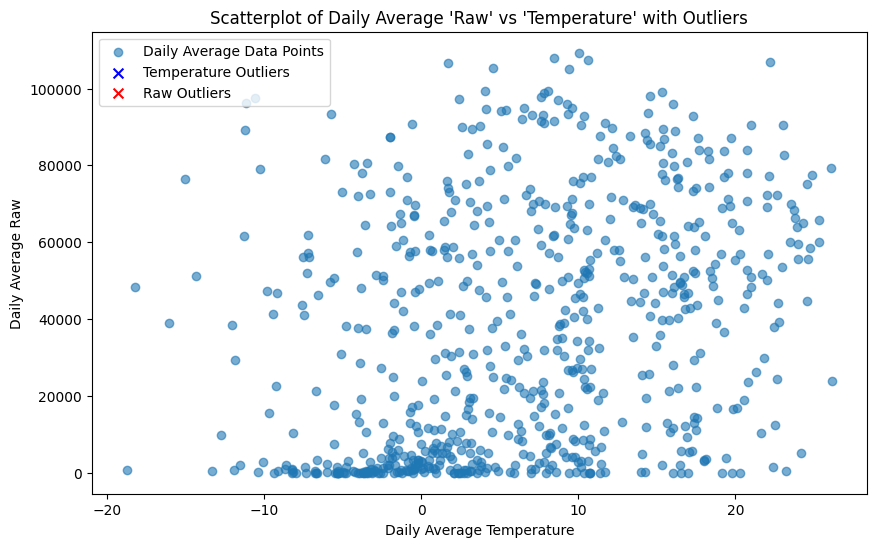

In [ ]:
# %%

# Outlier Detection for Daily Data
# Z-score method on daily data with threshold of 3 standard deviations
daily_data['temp_z_score'] = (daily_data['temperature'] -
                              daily_data['temperature'].mean()) / daily_data['temperature'].std()
daily_data['raw_z_score'] = (
    daily_data['raw'] - daily_data['raw'].mean()) / daily_data['raw'].std()

# Identifying outliers in daily data
daily_temp_outliers = daily_data[daily_data['temp_z_score'].abs() > 3]
daily_raw_outliers = daily_data[daily_data['raw_z_score'].abs() > 3]

# Scatterplot of Daily Average 'Raw' vs 'Temperature' with Outliers
plt.figure(figsize=(10, 6))
plt.scatter(daily_data['temperature'], daily_data['raw'],
            label='Daily Average Data Points', alpha=0.6)
plt.scatter(daily_temp_outliers['temperature'], daily_temp_outliers['raw'],
            color='blue', label='Temperature Outliers', s=50, marker='x')
plt.scatter(daily_raw_outliers['temperature'], daily_raw_outliers['raw'],
            color='red', label='Raw Outliers', s=50, marker='x')
plt.title("Scatterplot of Daily Average 'Raw' vs 'Temperature' with Outliers")
plt.xlabel("Daily Average Temperature")
plt.ylabel("Daily Average Raw")
plt.legend()
plt.show()

# %% [markdown]

 Analyzing daily trends and averages showed better picture for outlier detection but did not reveal significant patterns or transformations
 (besides obvious seasonal pattern for such data) that would further improve data normalization.

In [ ]:
# %%

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# %% [markdown]

 **1. Data Loading and Cleaning**

In [ ]:
# %%

# Load the dataset
data = pd.read_csv('data/solar_232215.csv', delimiter=',', decimal='.')
# Delete unnecessary columns if they exist
data.drop(['modified1', 'modified2', 'modified3'],
          axis=1, inplace=True, errors='ignore')
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
data.set_index('timestamp', inplace=True)

# Display the first few rows of the data
data.head()

# Extract the solar output column
raw = data['raw']

data

,raw,temperature
timestamp,,
2021-02-02 00:00:00,0.0,-3.9
2021-02-02 01:00:00,0.0,-3.5
2021-02-02 02:00:00,0.0,-3.0
2021-02-02 03:00:00,0.0,-2.6
2021-02-02 04:00:00,0.0,-2.4
...,...,...
2023-02-01 19:00:00,0.0,0.0
2023-02-01 20:00:00,0.0,0.1
2023-02-01 21:00:00,0.0,0.1


# %% [markdown]

 **2. Additive Classical Decomposition with Multiple Periods**


Decomposition with period: 24 hours


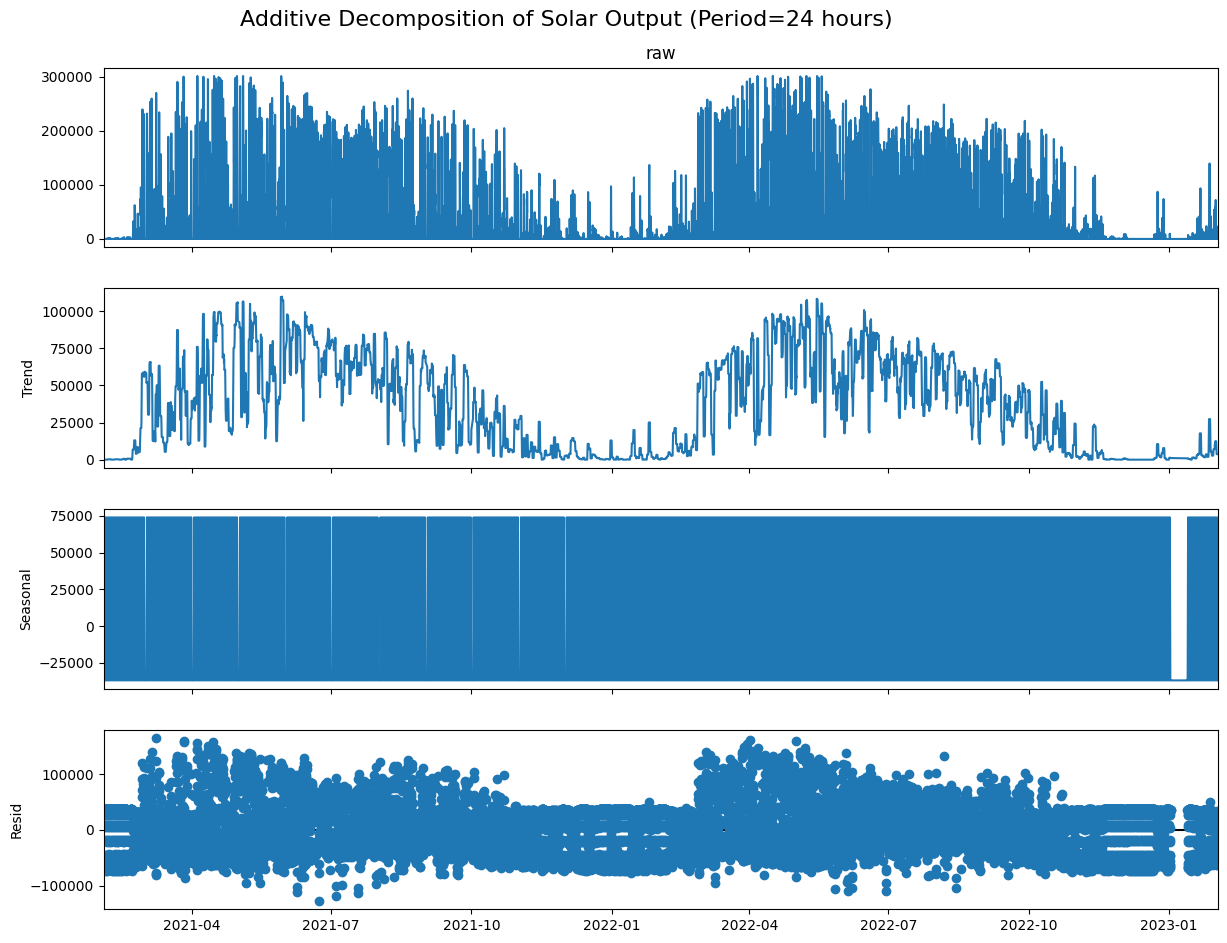


Decomposition with period: 168 hours


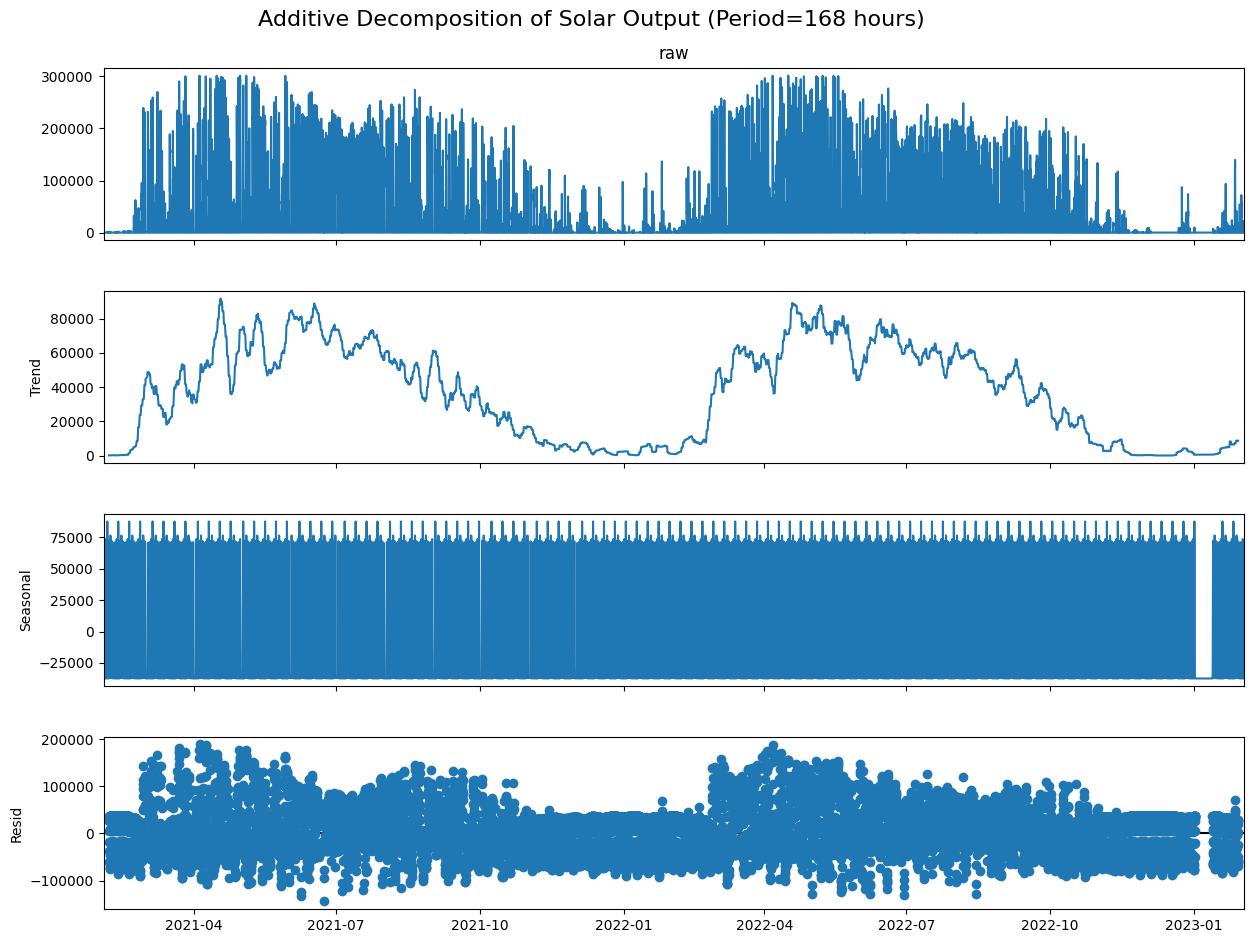


Decomposition with period: 720 hours


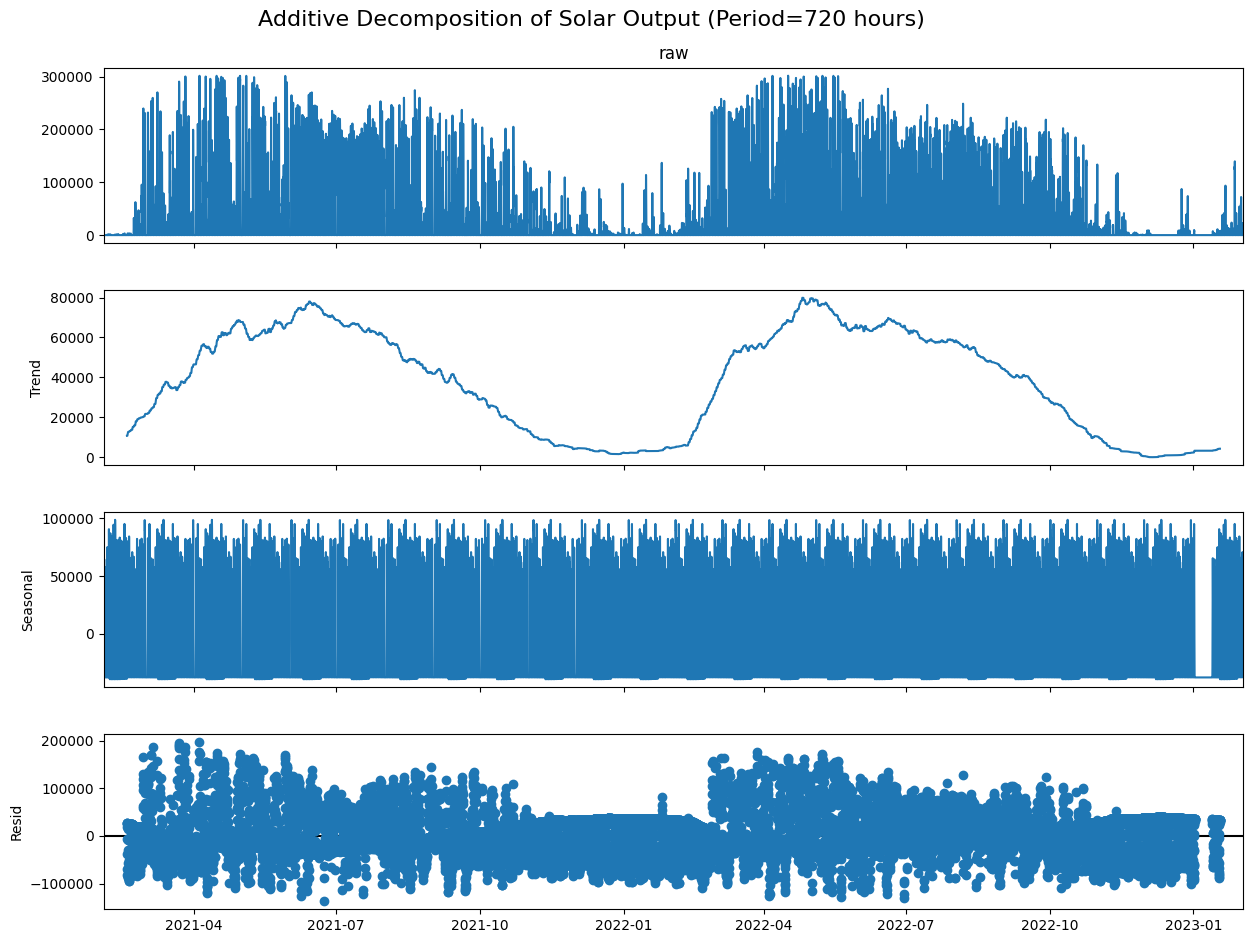

In [ ]:
# %%

# Testing decomposition with different periods to find the optimal one for solar generation
# 24 hours (daily), 168 hours (weekly), and 720 hours (monthly)
periods = [24, 168, 720]
decomposition_results = {}

for period in periods:
    print(f"\nDecomposition with period: {period} hours")
    decomposition = seasonal_decompose(
        raw, model='additive', period=period)
    decomposition_results[period] = decomposition

    # Plot the decomposition components
    fig = decomposition.plot()
    fig.set_size_inches(14, 10)
    plt.suptitle(
        f'Additive Decomposition of Solar Output (Period={period} hours)', fontsize=16)
    plt.show()

# %% [markdown]

 **3. Comparison of Decomposition Periods**

In [ ]:
# %%

# Analyze each period's effectiveness in capturing solar generation patterns

print("Comparing decomposition periods for solar generation insights:")

for period, decomposition in decomposition_results.items():
    # Calculate variance explained by the seasonal component for each period
    seasonal_variance = decomposition.seasonal.var()
    residual_variance = decomposition.resid.var()
    explained_ratio = seasonal_variance / \
        (seasonal_variance + residual_variance)

    print(f"Period {period} hours:")
    print(f" - Seasonal Variance: {seasonal_variance:.2f}")
    print(f" - Residual Variance: {residual_variance:.2f}")
    print(f" - Seasonal Variance Explained Ratio: {explained_ratio:.2%}\n")

# The period with the highest seasonal variance explained ratio is considered optimal
optimal_period = max(decomposition_results, key=lambda p: decomposition_results[p].seasonal.var(
) / (decomposition_results[p].seasonal.var() + decomposition_results[p].resid.var()))

print(
    f"The optimal decomposition period for solar generation analysis is {optimal_period} hours.")

Comparing decomposition periods for solar generation insights:
Period 24 hours:
 - Seasonal Variance: 1842630016.38
 - Residual Variance: 1638419875.77
 - Seasonal Variance Explained Ratio: 52.93%

Period 168 hours:
 - Seasonal Variance: 1877705376.41
 - Residual Variance: 1866758981.66
 - Seasonal Variance Explained Ratio: 50.15%

Period 720 hours:
 - Seasonal Variance: 2039561752.20
 - Residual Variance: 1904444605.99
 - Seasonal Variance Explained Ratio: 51.71%

The optimal decomposition period for solar generation analysis is 24 hours.


# %% [markdown]

 **4. Description of Decomposition Components for Optimal Period**

In [ ]:
# %%

# Display components for the optimal period

optimal_decomposition = decomposition_results[optimal_period]

print("Observed Component (Optimal Period):")
display(optimal_decomposition.observed.head())

print("\nTrend Component (Optimal Period):")
display(optimal_decomposition.trend.head())

print("\nSeasonal Component (Optimal Period):")
# Displaying a full day's seasonality if period=24
display(optimal_decomposition.seasonal.head(25))

print("\nResidual Component (Optimal Period):")
display(optimal_decomposition.resid.head())

Observed Component (Optimal Period):


timestamp
2021-02-02 00:00:00    0.0
2021-02-02 01:00:00    0.0
2021-02-02 02:00:00    0.0
2021-02-02 03:00:00    0.0
2021-02-02 04:00:00    0.0
Name: raw, dtype: float64


Trend Component (Optimal Period):


timestamp
2021-02-02 00:00:00   NaN
2021-02-02 01:00:00   NaN
2021-02-02 02:00:00   NaN
2021-02-02 03:00:00   NaN
2021-02-02 04:00:00   NaN
Name: trend, dtype: float64


Seasonal Component (Optimal Period):


timestamp
2021-02-02 00:00:00   -36965.416451
2021-02-02 01:00:00   -36965.677387
2021-02-02 02:00:00   -36765.418610
2021-02-02 03:00:00   -34753.304942
2021-02-02 04:00:00   -28130.686665
2021-02-02 05:00:00    -9197.399391
2021-02-02 06:00:00    17672.570693
2021-02-02 07:00:00    46369.674917
2021-02-02 08:00:00    62218.806527
2021-02-02 09:00:00    71872.656880
2021-02-02 10:00:00    74030.860750
2021-02-02 11:00:00    69848.786979
2021-02-02 12:00:00    61805.069201
2021-02-02 13:00:00    44234.328467
2021-02-02 14:00:00    20891.308425
2021-02-02 15:00:00    -5213.503863
2021-02-02 16:00:00   -27001.598750
2021-02-02 17:00:00   -33313.722423
2021-02-02 18:00:00   -35898.089894
2021-02-02 19:00:00   -36885.207674
2021-02-02 20:00:00   -36961.831489
2021-02-02 21:00:00   -36963.062630
2021-02-02 22:00:00   -36964.189067
2021-02-02 23:00:00   -36964.953600
2021-02-03 00:00:00   -36965.416451
Name: seasonal, dtype: float64


Residual Component (Optimal Period):


timestamp
2021-02-02 00:00:00   NaN
2021-02-02 01:00:00   NaN
2021-02-02 02:00:00   NaN
2021-02-02 03:00:00   NaN
2021-02-02 04:00:00   NaN
Name: resid, dtype: float64

# %% [markdown]

 **5. Creation of Typical Generation Profiles**

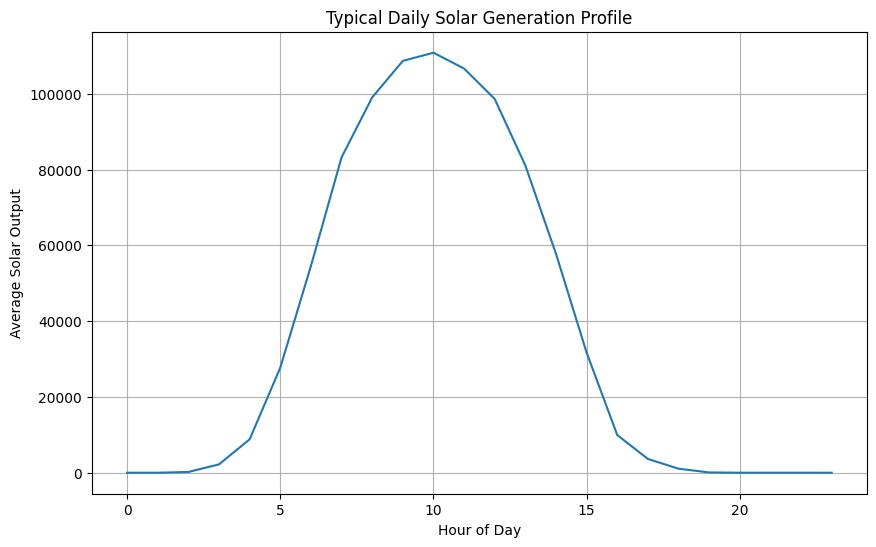

In [ ]:
# %%

# Extract hour, month, and season for profiling
data['hour'] = data.index.hour
data['month'] = data.index.month

# Define function to assign seasons based on month


def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'


data['season'] = data['month'].apply(get_season)

# Ensure the raw column is correctly named
solar_column = 'raw'  # Replace with actual column name if different

# Calculate and plot the typical daily profile
hourly_profile = data.groupby('hour')[solar_column].mean()
plt.figure(figsize=(10, 6))
hourly_profile.plot()
plt.title('Typical Daily Solar Generation Profile')
plt.xlabel('Hour of Day')
plt.ylabel('Average Solar Output')
plt.grid(True)
plt.show()

# %% [markdown]

 **6. Monthly Profile of Solar Output**

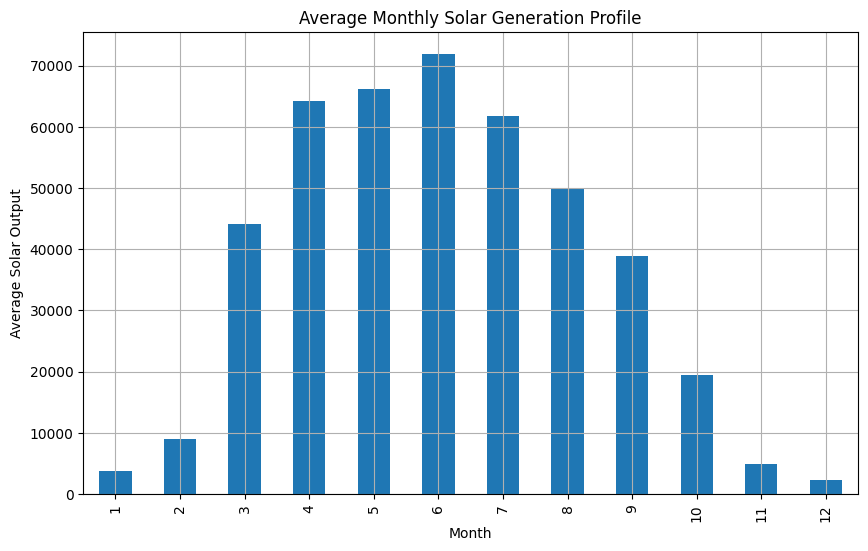

In [ ]:
# %%

# Calculate average solar output for each month and plot
monthly_profile = data.groupby('month')[solar_column].mean()
plt.figure(figsize=(10, 6))
monthly_profile.plot(kind='bar')
plt.title('Average Monthly Solar Generation Profile')
plt.xlabel('Month')
plt.ylabel('Average Solar Output')
plt.grid(True)
plt.show()

# %% [markdown]

 **7. Seasonal Hourly Profiles**

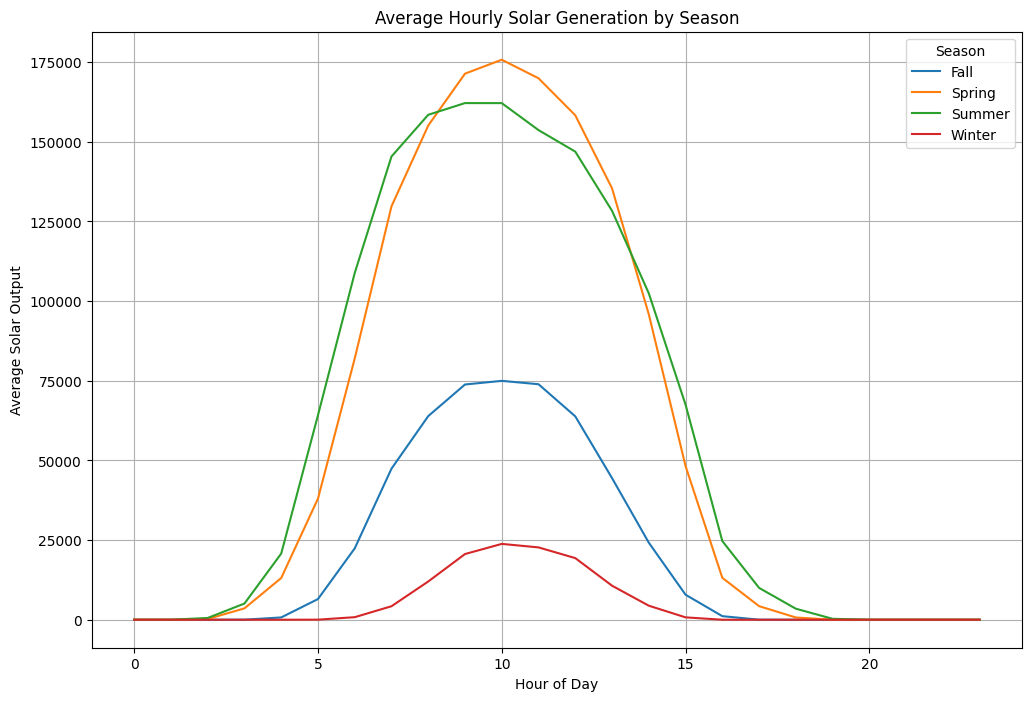

In [ ]:
# %%

# Calculate and plot average hourly solar output for each season
seasonal_profiles = data.groupby(['season', 'hour'])[
    solar_column].mean().unstack('season')
seasonal_profiles.plot(figsize=(12, 8))
plt.title('Average Hourly Solar Generation by Season')
plt.xlabel('Hour of Day')
plt.ylabel('Average Solar Output')
plt.legend(title='Season')
plt.grid(True)
plt.show()

# %% [markdown]

 **8. Methodology Explanation**

# %% [markdown]

 **Methodology Explanation:**

 *Additive Classical Decomposition with Multiple Periods:*
 - Tested decomposition with daily (24 hours), weekly (168 hours), and monthly (720 hours) periods.
 - Optimal period selected based on the highest ratio of variance explained by the seasonal component.

 *Typical Generation Profiles:*
 - **Hourly Profile:** Averages solar output at each hour across days for typical daily pattern.
 - **Monthly Profile:** Averages solar output by month to observe annual variation.
 - **Seasonal Profiles:** Uses seasonal grouping for average hourly output per season.

 **Rationale:**
 - Understanding these patterns aids in energy production forecasting and optimization.
 - Facilitates planning for storage and grid management.

# %% [markdown]

 ### Summary and Conclusion
 - **Optimal Decomposition Period:** The optimal period selected for decomposition (24 hours) captures the cyclical nature of solar generation effectively.
 - **Profile Analysis:** Created to understand daily, monthly, and seasonal solar patterns.
 **Additional Notes:**
 Replace `'raw'` with the actual column name if different.
 Libraries needed: `pandas`, `matplotlib`, `statsmodels`, `numpy`.